In [1]:
from PIL import Image
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from matplotlib import image as pimg
import copy
from sklearn import metrics
import scipy.spatial.distance as dst
import math
import pandas as pd
import pyeeg
import putemg_features
from typing import List, Dict, Sized
import os
import re
import glob
import time
from IPython.display import clear_output
# from scipy.ndimage.morphology import binary_dilation, binary_erosion
# from putemg_features import biolab_utilities as bu
# import tensorflow as tf

ModuleNotFoundError: No module named 'pyeeg'

- Scikit-learn не може використовувати тензори Тензорфлоу, але може працювати з Тензорфлоу-моделями(estimator)
- Я можу запустити Тензорфлоу модель на GPU в Google colab

1. Почергово взяти послідовності амплітуд, що відповідають процесу виконання руху та привести їх до однакової довжини 
**m = argmax(splits\[n-1\] - splits\[n\])** <br>
**length = df.loc\[m:m+1\].length()** <br>
**N_rows = length - df.loc\[n:n+1\].length()**<br>
**d = pd.DataFrame(np.zeros((N_rows, N_cols)))**<br>
DataFrame.fillna(value=None, method=None, axis=None, inplace=False, limit=None, downcast=None) <br>
2. Перетворити послідовності амплітуд  у Tensor об'єкти за допомогою
tf.cast(df.values, ...) <br>
3. Покласти їх у TensorArray: <br>
ta = tf.TensorArray(tf.float32, size=0, dynamic_size=True, clear_after_read=False) <br/>
ta = ta.write(index, Tensor)

4. TensorArray.stack() щоб перетворити список у тензор більшого порядку
5. Покласти тензор в Dataset
6. Записати Dataset в файл <br/><br/><br/>
DataFrame.asfreq(freq, method=None, how=None, normalize=False, fill_value=None)

## Розбиття на ділянки з різними станами

In [26]:
EMG_Frame_filetered = pd.read_hdf('./gestures_repeats_short_filtered/emg_gestures-08-repeats_short-2018-04-11-08-38-56-728_filtered.hdf5')

In [30]:
splits = EMG_Frame_filetered[EMG_Frame_filetered['TRAJ_GT'] != EMG_Frame_filetered['TRAJ_GT'].shift(-1)].index

In [31]:
EMG_Frame_filetered['intrvl'] = pd.cut(EMG_Frame_filetered.index, bins=splits.to_numpy(), labels=False)

### Не всі набори співпадають за послідовністю станів кінцівки
Потрібен алгоритм на основі закономірності в послідовності станів в різних випробуваннях

### Ідіома для пошуку індексу першого та останньго справдження умови в DataFrame

In [77]:
print(EMG_Frame_filetered['TRAJ_GT'].where(EMG_Frame_filetered['TRAJ_GT'] == 9.0).first_valid_index()[0], EMG_Frame_filetered['TRAJ_GT'].where(EMG_Frame_filetered['TRAJ_GT'] == 9.0).last_valid_index()[0])

81.0 89.0


In [48]:
frm = pd.DataFrame(index=[[],[]])

dich = EMG_Frame_filetered.loc[range(fist[0], fist[1], step)]
dich.reset_index(level=0, inplace=True)
dich.set_index(['intrvl', dich.index], inplace=True)

lvls = dich.index.levels[0]
idx = lvls.map(lambda x: np.where(lvls.to_numpy() == x)[0][0] + len(frm.index.levels[0]))
dich.index.set_levels(idx, 'intrvl', inplace=True)

frm = frm.append(dich)
frm


EMG_1      EMG_2      EMG_3      EMG_4      EMG_5  \
intrvl                                                                    
0      8.165461    6.034247 -18.758258 -16.046438 -11.602450  -0.655309   
       8.165656  -11.529084 -24.371089 -21.855344 -16.753563  -5.564103   
       8.165851  -25.065751 -25.945544 -25.677200 -20.436744  -9.532025   
       8.166046  -33.256629 -22.961727 -26.538378 -21.802027 -11.751410   
       8.166241  -36.215667 -16.359310 -24.291973 -20.627834 -11.974914   
...                     ...        ...        ...        ...        ...   
5      35.566404  -5.764946   1.490515  -0.408118   2.519560   5.109672   
       35.566599  -6.645331   0.303489  -1.619874   1.446887   3.834508   
       35.566794  -9.697912  -2.506703  -4.140806  -1.314381   0.861212   
       35.566989 -14.165721  -6.321651  -7.434891  -5.108368  -3.074557   
       35.567184 -18.440430  -9.785564 -10.330575  -8.558597  -6.508961   

                      EMG_6      EMG_7      EMG_8      EMG_9     EMG_10  ...  \
intrvl                                                                   ...   
0      8.165461    1.641783  11.502913   7.487509  19.883336 -44.056443  ...   
       8.165656   -3.627099   4.837523  -2.013672   7.569377 -47.167292  ...   
       8.165851   -8.478981  -1.632061  -9.970497  -2.200034 -48.063580  ...   
       8.166046  -11.891028  -6.896903 -15.319532  -8.850808 -45.135301  ...   
       8.166241  -13.371595 -10.404008 -18.014289 -12.660001 -38.018804  ...   
...                     ...        ...        ...        ...        ...  ...   
5      35.566404   8.429698  10.255309   7.410312   4.543838   4.523938  ...   
       35.566599   6.813154   7.784400   5.998447   3.295240   3.224826  ...   
       35.566794   2.747031   2.836899   2.522257   0.311910   0.321475  ...   
       35.566989  -2.893996  -3.692078  -2.428933  -3.756666  -3.535206  ...   
       35.567184  -8.281833 -10.066443  -7.438301  -7.540694  -7.023078  ...   

                     EMG_16     EMG_17     EMG_18     EMG_19     EMG_20  \
intrvl                                                                    
0      8.165461   20.026417  25.150893  12.106519 -10.840710 -11.629199   
       8.165656    8.607223  13.878185   4.371766 -13.437371 -15.017354   
       8.165851   -0.486435   5.022224  -1.815925 -15.521811 -18.142898   
       8.166046   -6.301380  -0.308191  -5.077878 -15.986238 -19.914929   
       8.166241   -8.987004  -2.093345  -5.058848 -14.336751 -19.615210   
...                     ...        ...        ...        ...        ...   
5      35.566404  11.900106   8.522364   7.484027   9.325234   7.260541   
       35.566599  10.818432   8.713890   7.133181   7.750515   6.271565   
       35.566794   8.094717   7.556248   5.556332   4.517211   4.077325   
       35.566989   4.238356   5.349312   2.978986   0.074601   1.076154   
       35.567184   0.479927   2.891985   0.155818  -4.506422  -1.850006   

                     EMG_21     EMG_22     EMG_23     EMG_24  TRAJ_GT  
intrvl                                                                 
0      8.165461   -5.319310   6.878799  12.765401  14.976494      1.0  
       8.165656   -9.622432   1.076433   3.525803   2.296174      1.0  
       8.165851  -13.426653  -4.368765  -5.476757  -9.158307      1.0  
       8.166046  -15.449367  -8.298079 -12.962294 -18.264052      1.0  
       8.166241  -14.983147 -10.066606 -18.141643 -24.498896      1.0  
...                     ...        ...        ...        ...      ...  
5      35.566404   9.009428   5.554867  10.132902  13.179781      1.0  
       35.566599   7.766084   4.421661   9.319942  11.982698      1.0  
       35.566794   4.910526   2.643265   7.816664   8.749791      1.0  
       35.566989   1.002800   0.486163   5.830688   4.049145      1.0  
       35.567184  -2.750510  -1.597446   3.734464  -0.731398      1.0  

[68140 rows x 25 columns]

In [2]:
putemg_folder = "./putEMG/Data-HDF5/"
filtered_data_folder = "./gestures_repeats_short_filtered"
sampled_data_folder = "./gestures_r_short_sampled"

In [3]:
filtered_files = [f for f in sorted(glob.glob(os.path.join(filtered_data_folder, "*.hdf5")))]

In [13]:
idleSamples = pd.DataFrame(index=[[],[]])
fistSamples = pd.DataFrame(index=[[],[]])
flexSamples = pd.DataFrame(index=[[],[]])
extSamples = pd.DataFrame(index=[[],[]])
pinch1_2Samples = pd.DataFrame(index=[[],[]])
pinch1_3Samples = pd.DataFrame(index=[[],[]])
pinch1_4Samples = pd.DataFrame(index=[[],[]])
pinch1_5Samples = pd.DataFrame(index=[[],[]])

In [8]:
def formDataset(rp_shrt: pd.DataFrame(index=[[],[]]), traj, res_levels, **kwargs):
    splt = kwargs.get('split', 
                      (rp_shrt['TRAJ_GT'].where(rp_shrt['TRAJ_GT'] == traj).first_valid_index()[0], 
                       rp_shrt['TRAJ_GT'].where(rp_shrt['TRAJ_GT'] == traj).last_valid_index()[0])
                     )
    print(splt)
    temp = rp_shrt.loc[range(int(splt[0]), int(splt[1] + 1.),2)]
    temp.reset_index(level=0,inplace=True)
    temp.set_index(['intrvl', temp.index], inplace=True)
    lvls = temp.index.levels[0]
    idx = lvls.map(lambda x: np.where(lvls.to_numpy() == x)[0][0] + res_levels)
    temp.index.set_levels(idx, 'intrvl', inplace=True)

    return temp

Одночасно наповнити всі масиви числами не вистачає оперативної пам'яті в 16 GB

## Розбиття на масиви семплів різних жестів

In [7]:
if not os.path.exists(sampled_data_folder):
            os.makedirs(sampled_data_folder)
for file in filtered_files:
            basename = os.path.basename(file)
            print('Splitting file: {:s}'.format(basename))

            # read raw putEMG data file and run filter
            df: pd.DataFrame = pd.read_hdf(file)
            splits = df[df['TRAJ_GT'] != df['TRAJ_GT'].shift(-1)].index
            df['intrvl'] = pd.cut(df.index, bins=splits.to_numpy(), labels=False)
            df.dropna(inplace=True)
            df.set_index(['intrvl',df.index], inplace=True)
            
#             idleSamples = idleSamples.append(formDataset(df, 0, len(idleSamples.index.levels[0])))
            
#             fistSamples = fistSamples.append(formDataset(df, 1, len(fistSamples.index.levels[0])))
#             flexSamples = flexSamples.append(formDataset(df, 2, len(flexSamples.index.levels[0])))
#             extSamples = extSamples.append(formDataset(df, 3, len(extSamples.index.levels[0])))
#             pinch1_2Samples = pinch1_2Samples.append(formDataset(df, 6, len(pinch1_2Samples.index.levels[0])))
#             pinch1_3Samples = pinch1_3Samples.append(formDataset(df, 7, len(pinch1_3Samples.index.levels[0])))
            pinch1_4Samples = pinch1_4Samples.append(formDataset(df, 8, len(pinch1_4Samples.index.levels[0])))
            pinch1_5Samples = pinch1_5Samples.append(formDataset(df, 9, len(pinch1_5Samples.index.levels[0])))
            del df
            del splits

# idleSamples.to_hdf(os.path.join(sampled_data_folder, '0_idle.hdf5'), 'data', format='table', mode='w', complevel=5)
# fistSamples.to_hdf(os.path.join(sampled_data_folder, '1_fist.hdf5'), 'data', format='table', mode='w', complevel=5)
# flexSamples.to_hdf(os.path.join(sampled_data_folder, '2_flexion.hdf5'), 'data', format='table', mode='w', complevel=5)
# extSamples.to_hdf(os.path.join(sampled_data_folder, '3_extension.hdf5'), 'data', format='table', mode='w', complevel=5)
# pinch1_2Samples.to_hdf(os.path.join(sampled_data_folder, '6_pinch1_2.hdf5'), 'data', format='table', mode='w', complevel=5)
# pinch1_3Samples.to_hdf(os.path.join(sampled_data_folder, '7_pinch1_3.hdf5'), 'data', format='table', mode='w', complevel=5)
pinch1_4Samples.to_hdf(os.path.join(sampled_data_folder, '8_pinch1_4.hdf5'), 'data', format='table', mode='w', complevel=5)
pinch1_5Samples.to_hdf(os.path.join(sampled_data_folder, '9_pinch1_5.hdf5'), 'data', format='table', mode='w', complevel=5)

Splitting file: emg_gestures-03-repeats_short-2018-05-11-11-15-21-403_filtered.hdf5
Splitting file: emg_gestures-03-repeats_short-2018-06-14-12-43-13-875_filtered.hdf5
Splitting file: emg_gestures-04-repeats_short-2018-03-28-12-53-43-859_filtered.hdf5
Splitting file: emg_gestures-04-repeats_short-2018-06-18-15-12-34-944_filtered.hdf5
Splitting file: emg_gestures-05-repeats_short-2018-04-04-08-42-37-751_filtered.hdf5
Splitting file: emg_gestures-05-repeats_short-2018-04-23-08-35-24-986_filtered.hdf5
Splitting file: emg_gestures-06-repeats_short-2018-04-04-14-15-20-266_filtered.hdf5
Splitting file: emg_gestures-06-repeats_short-2018-04-16-08-46-42-440_filtered.hdf5
Splitting file: emg_gestures-07-repeats_short-2018-04-04-11-52-48-698_filtered.hdf5
Splitting file: emg_gestures-07-repeats_short-2018-05-11-13-04-19-653_filtered.hdf5
Splitting file: emg_gestures-08-repeats_short-2018-04-04-15-59-18-716_filtered.hdf5
Splitting file: emg_gestures-08-repeats_short-2018-04-11-08-38-56-728_filter

/home/master/miniconda3/lib/python3.8/site-packages/tables/file.py:426: UserWarning: a closed node found in the registry: ``/data/meta/values_block_3/meta/_i_table``
  warnings.warn("a closed node found in the registry: "


In [14]:
if not os.path.exists(sampled_data_folder):
            os.makedirs(sampled_data_folder)
for file in filtered_files:
            basename = os.path.basename(file)
            print('Splitting file: {:s}'.format(basename))

            # read raw putEMG data file and run filter
            df: pd.DataFrame = pd.read_hdf(file)
            splits = df[df['TRAJ_GT'] != df['TRAJ_GT'].shift(-1)].index
            df['intrvl'] = pd.cut(df.index, bins=splits.to_numpy(), labels=False)
            df.dropna(inplace=True)
            df.set_index(['intrvl',df.index], inplace=True)
            
            idleSamples = idleSamples.append(formDataset(df, 0, len(idleSamples.index.levels[0]), split=(0, 11)))
            
#             fistSamples = fistSamples.append(formDataset(df, 1, len(fistSamples.index.levels[0])))
#             flexSamples = flexSamples.append(formDataset(df, 2, len(flexSamples.index.levels[0])))
#             extSamples = extSamples.append(formDataset(df, 3, len(extSamples.index.levels[0])))
#             pinch1_2Samples = pinch1_2Samples.append(formDataset(df, 6, len(pinch1_2Samples.index.levels[0])))
#             pinch1_3Samples = pinch1_3Samples.append(formDataset(df, 7, len(pinch1_3Samples.index.levels[0])))
#             pinch1_4Samples = pinch1_4Samples.append(formDataset(df, 8, len(pinch1_4Samples.index.levels[0])))
#             pinch1_5Samples = pinch1_5Samples.append(formDataset(df, 9, len(pinch1_5Samples.index.levels[0])))
            del df
            del splits

idleSamples.to_hdf(os.path.join(sampled_data_folder, '0_idle.hdf5'), 'data', format='table', mode='w', complevel=5)
# fistSamples.to_hdf(os.path.join(sampled_data_folder, '1_fist.hdf5'), 'data', format='table', mode='w', complevel=5)
# flexSamples.to_hdf(os.path.join(sampled_data_folder, '2_flexion.hdf5'), 'data', format='table', mode='w', complevel=5)
# extSamples.to_hdf(os.path.join(sampled_data_folder, '3_extension.hdf5'), 'data', format='table', mode='w', complevel=5)
# pinch1_2Samples.to_hdf(os.path.join(sampled_data_folder, '6_pinch1_2.hdf5'), 'data', format='table', mode='w', complevel=5)
# pinch1_3Samples.to_hdf(os.path.join(sampled_data_folder, '7_pinch1_3.hdf5'), 'data', format='table', mode='w', complevel=5)
# pinch1_4Samples.to_hdf(os.path.join(sampled_data_folder, '8_pinch1_4.hdf5'), 'data', format='table', mode='w', complevel=5)
# pinch1_5Samples.to_hdf(os.path.join(sampled_data_folder, '9_pinch1_5.hdf5'), 'data', format='table', mode='w', complevel=5)

Splitting file: emg_gestures-03-repeats_short-2018-05-11-11-15-21-403_filtered.hdf5
(0, 11)
Splitting file: emg_gestures-03-repeats_short-2018-06-14-12-43-13-875_filtered.hdf5
(0, 11)
Splitting file: emg_gestures-04-repeats_short-2018-03-28-12-53-43-859_filtered.hdf5
(0, 11)
Splitting file: emg_gestures-04-repeats_short-2018-06-18-15-12-34-944_filtered.hdf5
(0, 11)
Splitting file: emg_gestures-05-repeats_short-2018-04-04-08-42-37-751_filtered.hdf5
(0, 11)
Splitting file: emg_gestures-05-repeats_short-2018-04-23-08-35-24-986_filtered.hdf5
(0, 11)
Splitting file: emg_gestures-06-repeats_short-2018-04-04-14-15-20-266_filtered.hdf5
(0, 11)
Splitting file: emg_gestures-06-repeats_short-2018-04-16-08-46-42-440_filtered.hdf5
(0, 11)
Splitting file: emg_gestures-07-repeats_short-2018-04-04-11-52-48-698_filtered.hdf5
(0, 11)
Splitting file: emg_gestures-07-repeats_short-2018-05-11-13-04-19-653_filtered.hdf5
(0, 11)
Splitting file: emg_gestures-08-repeats_short-2018-04-04-15-59-18-716_filtered.h

/home/master/miniconda3/lib/python3.8/site-packages/tables/file.py:426: UserWarning: a closed node found in the registry: ``/data/meta/values_block_3/meta/_i_table``
  warnings.warn("a closed node found in the registry: "


In [15]:
idleSamples

EMG_1      EMG_2      EMG_3      EMG_4      EMG_5  \
intrvl                                                                   
0      5.008805   0.545447   0.208629  -0.115538  -1.151773  -2.265033   
       5.009000   0.031476  -0.025516  -0.636038  -1.690819  -2.970912   
       5.009195   0.287448   0.362198  -0.674356  -1.475029  -2.875545   
       5.009391   1.082392   1.031914  -0.316099  -0.750917  -2.198720   
       5.009586   1.919659   1.497140   0.158679   0.031259  -1.387832   
...                    ...        ...        ...        ...        ...   
521    28.521888  3.095449  -2.351523  -6.967205  -8.634173  -9.662236   
       28.522084  4.972712  -1.299210  -6.587056  -9.173964 -10.794304   
       28.522279  4.081035  -3.007123  -8.797880 -12.034535 -14.262590   
       28.522474  0.533459  -7.274847 -13.338795 -16.752032 -19.491870   
       28.522669 -4.517042 -12.979234 -19.080185 -22.185704 -25.289834   

                      EMG_6      EMG_7      EMG_8     EMG_9     EMG_10  ...  \
intrvl                                                                  ...   
0      5.008805   -3.014057  -2.534523  -3.308310  0.216875  -1.037744  ...   
       5.009000   -3.797279  -2.374617  -3.573538  0.031924  -1.400148  ...   
       5.009195   -3.880021  -1.946919  -3.270113  0.419616  -0.996939  ...   
       5.009391   -3.235369  -1.289671  -2.544976  1.067571  -0.157192  ...   
       5.009586   -2.234014  -0.644402  -1.767249  1.556569   0.613247  ...   
...                     ...        ...        ...       ...        ...  ...   
521    28.521888 -13.933997 -14.258747 -18.594380  5.706431  -5.128699  ...   
       28.522084 -14.961461 -14.605505 -19.148992  4.777057  -4.667979  ...   
       28.522279 -18.343142 -17.685962 -22.283610  1.495368  -6.785211  ...   
       28.522474 -23.773202 -23.053676 -27.631192 -3.741154 -11.255170  ...   
       28.522669 -30.167048 -29.415197 -33.909982 -9.745428 -16.984751  ...   

                     EMG_23     EMG_24  TRAJ_1          type  subject  \
intrvl                                                                  
0      5.008805   -0.162639   0.585228     0.0  emg_gestures      3.0   
       5.009000   -0.054550   0.050945     0.0  emg_gestures      3.0   
       5.009195    0.283324   0.112185     0.0  emg_gestures      3.0   
       5.009391    0.662943   0.669707     0.0  emg_gestures      3.0   
       5.009586    0.872283   1.344123     0.0  emg_gestures      3.0   
...                     ...        ...     ...           ...      ...   
521    28.521888  -5.516888  -8.045745     1.0  emg_gestures     54.0   
       28.522084  -6.443278  -8.641731     1.0  emg_gestures     54.0   
       28.522279  -9.268293 -11.018956     1.0  emg_gestures     54.0   
       28.522474 -13.698881 -15.017381     1.0  emg_gestures     54.0   
       28.522669 -18.810470 -19.744213     1.0  emg_gestures     54.0   

                     trajectory               date_time  TRAJ_GT_NO_FILTER  \
intrvl                                                                       
0      5.008805   repeats_short 2018-05-11 11:15:21.403                0.0   
       5.009000   repeats_short 2018-05-11 11:15:21.403                0.0   
       5.009195   repeats_short 2018-05-11 11:15:21.403                0.0   
       5.009391   repeats_short 2018-05-11 11:15:21.403                0.0   
       5.009586   repeats_short 2018-05-11 11:15:21.403                0.0   
...                         ...                     ...                ...   
521    28.521888  repeats_short 2018-05-11 14:05:34.118                0.0   
       28.522084  repeats_short 2018-05-11 14:05:34.118                0.0   
       28.522279  repeats_short 2018-05-11 14:05:34.118                0.0   
       28.522474  repeats_short 2018-05-11 14:05:34.118                0.0   
       28.522669  repeats_short 2018-05-11 14:05:34.118                0.0   

                  VIDEO_STAMP  TRAJ_GT  
intrvl                  

In [52]:
MovesFrame = pd.read_hdf(putemg_folder + "emg_gestures-03-repeats_short-2018-05-11-11-15-21-403.hdf5")

## Фільтрація сигналів різних піддослідних та складання в одну директорію

In [4]:
all_files = [f for f in sorted(glob.glob(os.path.join(putemg_folder, "*gestures*repeats_short*.hdf5")))]

In [8]:
all_files[82:]

['./putEMG/Data-HDF5/emg_gestures-51-repeats_short-2018-04-26-10-30-44-855.hdf5',
 './putEMG/Data-HDF5/emg_gestures-51-repeats_short-2018-05-09-13-43-35-444.hdf5',
 './putEMG/Data-HDF5/emg_gestures-53-repeats_short-2018-04-26-16-31-59-711.hdf5',
 './putEMG/Data-HDF5/emg_gestures-53-repeats_short-2018-05-10-15-58-46-706.hdf5',
 './putEMG/Data-HDF5/emg_gestures-54-repeats_short-2018-04-27-14-14-48-078.hdf5',
 './putEMG/Data-HDF5/emg_gestures-54-repeats_short-2018-05-11-14-05-34-118.hdf5']

In [9]:
if not os.path.exists(filtered_data_folder):
            os.makedirs(filtered_data_folder)
for file in all_files[82:]:
            basename = os.path.basename(file)
            filename = os.path.splitext(basename)[0]
            print('Denoising file: {:s}'.format(basename))

            # read raw putEMG data file and run filter
            df: pd.DataFrame = pd.read_hdf(file)
            bu.apply_filter(df)

            # save filtered data to designated folder with prefix filtered_
            output_file = filename + '_filtered.hdf5'
            print('Saving to file: {:s}'.format(output_file))
            df.to_hdf(os.path.join(filtered_data_folder, output_file),
                      'data', format='table', mode='w', complevel=5)

Denoising file: emg_gestures-51-repeats_short-2018-04-26-10-30-44-855.hdf5
Processing channel:  EMG_1 EMG_2 EMG_3 EMG_4 EMG_5 EMG_6 EMG_7 EMG_8 EMG_9 EMG_10 EMG_11 EMG_12 EMG_13 EMG_14 EMG_15 EMG_16 EMG_17 EMG_18 EMG_19 EMG_20 EMG_21 EMG_22 EMG_23 EMG_24
Elapsed time: 277.26s
Saving to file: emg_gestures-51-repeats_short-2018-04-26-10-30-44-855_filtered.hdf5


/home/master/miniconda3/lib/python3.8/site-packages/tables/file.py:426: UserWarning: a closed node found in the registry: ``/data/meta/values_block_2/meta/_i_table``
  warnings.warn("a closed node found in the registry: "


Denoising file: emg_gestures-51-repeats_short-2018-05-09-13-43-35-444.hdf5
Processing channel:  EMG_1 EMG_2 EMG_3 EMG_4 EMG_5 EMG_6 EMG_7 EMG_8 EMG_9 EMG_10 EMG_11 EMG_12 EMG_13 EMG_14 EMG_15 EMG_16 EMG_17 EMG_18 EMG_19 EMG_20 EMG_21 EMG_22 EMG_23 EMG_24
Elapsed time: 282.29s
Saving to file: emg_gestures-51-repeats_short-2018-05-09-13-43-35-444_filtered.hdf5
Denoising file: emg_gestures-53-repeats_short-2018-04-26-16-31-59-711.hdf5
Processing channel:  EMG_1 EMG_2 EMG_3 EMG_4 EMG_5 EMG_6 EMG_7 EMG_8 EMG_9 EMG_10 EMG_11 EMG_12 EMG_13 EMG_14 EMG_15 EMG_16 EMG_17 EMG_18 EMG_19 EMG_20 EMG_21 EMG_22 EMG_23 EMG_24
Elapsed time: 275.58s
Saving to file: emg_gestures-53-repeats_short-2018-04-26-16-31-59-711_filtered.hdf5
Denoising file: emg_gestures-53-repeats_short-2018-05-10-15-58-46-706.hdf5
Processing channel:  EMG_1 EMG_2 EMG_3 EMG_4 EMG_5 EMG_6 EMG_7 EMG_8 EMG_9 EMG_10 EMG_11 EMG_12 EMG_13 EMG_14 EMG_15 EMG_16 EMG_17 EMG_18 EMG_19 EMG_20 EMG_21 EMG_22 EMG_23 EMG_24
Elapsed time: 285.26s
S

In [26]:
MovesFrame.insert(0,'time', MovesFrame.index)
MovesFrame.index = np.arange(MovesFrame.shape[0])

In [27]:
ParticipantsFrame = pd.read_csv('./putEMG/putEMG-participants.csv', sep=';')

In [28]:
ParticipantsFrame.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44 entries, 0 to 43
Data columns (total 19 columns):
 #   Column                                                                 Non-Null Count  Dtype  
---  ------                                                                 --------------  -----  
 0   ID                                                                     44 non-null     int64  
 1   Gender [F/M]                                                           44 non-null     object 
 2   Age [years]                                                            44 non-null     int64  
 3   Height [cm]                                                            44 non-null     int64  
 4   Weight [kg]                                                            44 non-null     float64
 5   Forearm diameter (elbow band) [cm]                                     44 non-null     float64
 6   Forearm diameter (wrist band) [cm]                                     44 non-null     float

## Dataset name: \<emg_gesture | emg_force\>-\<subject\>-\<trajectory\>-\<YYYY-MM-DD-hh-mm-ss-milisec\>
### frequency = 5124.07211903 Hz
### subject = participant number from 3 to 54
## trajectory in Dataset names
### repeats_long - 7 action blocks, each block contains 8 repetitions of each active gesture:
### bias – force sensor bias acquisition trajectory, from this trajectory a sensor bias is extracted, and subtracted from each succeeding force trajectories;<br>
### mvc – contains only one step, when subject was asked to squezze the dynamometer as hard as possible;<br>
### repeats_long – 5 action blocks, each press type repeated 11 times with varying parameters;<br>
### sequential – 4 action blocks, each block is a repeated two times subsequent execution of each press type, with varying parameters;<br>
### repeats_short – 5 action blocks, each press type repeated 5 times with varying parameters.
### \[relax\] 0-1-0-1-0-1-0-1-0-1-0-1-0-1-0-1-0 \[relax\] 0-2-0-2-0-2-0-2-0-2-0-2-0-2-0-2-0 \[relax\] 0-3-0... ,
### sequential - 6 action blocks, each block is a subsequent execution of all active gestures:
### \[relax\] 0-1-0-2-0-3-0-6-0-7-0-8-0-9-0 \[relax\] 0-1-0-2-0-3-0-6-0-7-0-8-0-9-0 \[relax\] 0-1-0-2-0... ,
### repeats_short - 7 action blocks, each block contains 6 repetitions of each active gesture:
### \[relax\] 0-1-0-1-0-1-0-1-0-1-0-1-0 \[relax\] 0-2-0-2-0-2-0-2-0-2-0-2-0 \[relax\] 0-3-0...
## Single Dataset
* FORCE_MVC = maximal voluntary contraction
* TRAJ_1 - label representing command shown to the subject during the experiment,
* TRAJ_GT_NO_FILTER - gesture recognised from the video stream, not processed,
* TRAJ_GT—ground - truth estimated from the video stream, processed as described in Section 2.4,
* VIDEO_STAMP - frame timestamp in the corresponding video stream.

In [55]:
MovesFrame.index

Float64Index([-0.026817122345221378, -0.026621965883699108,
              -0.026426809422176838, -0.026231652960654567,
              -0.026036496499132294, -0.025841340037610024,
              -0.025646183576087753, -0.025451027114565483,
              -0.025255870653043213, -0.025060714191520943,
              ...
                  270.9545650210194,     270.9547601774809,
                 270.95495533394245,      270.955150490404,
                 270.95534564686545,      270.955540803327,
                  270.9557359597885,    270.95593111625004,
                  270.9561262727116,     270.9563214291731],
             dtype='float64', length=1388544)

In [11]:
MovesFrame.shape[0]

1388544

In [31]:
clmns = MovesFrame.columns[MovesFrame.columns.str.contains('EMG')].tolist()
clmns.append('TRAJ_GT')
EMG_Frame = MovesFrame[ clmns ]

In [32]:
EMG_Frame

EMG_1  EMG_2  EMG_3  EMG_4  EMG_5  EMG_6  EMG_7  EMG_8  EMG_9  \
0          4.0    5.0    4.0    3.0    2.0    4.0    4.0    4.0    2.0   
1          6.0    6.0    7.0    7.0    6.0    5.0    6.0    6.0    4.0   
2         14.0   14.0   14.0   13.0   14.0   10.0   14.0   13.0   10.0   
3         21.0   20.0   20.0   18.0   20.0   14.0   20.0   19.0   15.0   
4         21.0   21.0   21.0   17.0   21.0   16.0   22.0   20.0   16.0   
...        ...    ...    ...    ...    ...    ...    ...    ...    ...   
1388539  -10.0  -12.0  -11.0   -3.0   -5.0   -4.0   -7.0   -7.0   -8.0   
1388540  -11.0  -11.0  -11.0   -4.0   -5.0   -5.0   -8.0   -8.0   -8.0   
1388541  -11.0  -12.0  -11.0   -4.0   -6.0   -6.0   -8.0   -9.0   -7.0   
1388542  -10.0  -11.0  -10.0   -3.0   -5.0   -6.0   -8.0   -9.0   -8.0   
1388543  -10.0  -10.0   -9.0   -2.0   -4.0   -5.0   -8.0   -8.0   -8.0   

         EMG_10  ...  EMG_16  EMG_17  EMG_18  EMG_19  EMG_20  EMG_21  EMG_22  \
0           4.0  ...    12.0     4.0     3.0     1.0     5.0     4.0     4.0   
1           5.0  ...    15.0     4.0     4.0     1.0     6.0     5.0     4.0   
2          13.0  ...    22.0     7.0     7.0     6.0     9.0     8.0     7.0   
3          20.0  ...    27.0    10.0    10.0     9.0    11.0    10.0    10.0   
4          20.0  ...    29.0    10.0    10.0     9.0    12.0    12.0     9.0   
...         ...  ...     ...     ...     ...     ...     ...     ...     ...   
1388539   -10.0  ...    -8.0    -6.0    -7.0   -11.0    18.0   -12.0    -7.0   
1388540   -10.0  ...    -7.0    -7.0    -8.0   -10.0    18.0   -12.0    -7.0   
1388541   -10.0  ...    -7.0    -8.0    -8.0   -10.0    17.0   -13.0    -8.0   
1388542    -9.0  ...    -8.0    -8.0    -7.0   -10.0    17.0   -13.0    -7.0   
1388543    -9.0  ...    -8.0    -7.0    -7.0   -10.0    18.0   -14.0    -8.0   

         EMG_23  EMG_24  TRAJ_GT  
0           4.0     4.0     -1.0  
1           4.0     5.0     -1.0  
2           8.0     8.0     -1.0  
3          10.0    10.0     -1.0  
4          10.0    10.0     -1.0  
...         ...     ...      ...  
1388539    -7.0    -5.0     -1.0  
1388540    -7.0    -7.0     -1.0  
1388541    -7.0    -7.0     -1.0  
1388542    -6.0    -6.0     -1.0  
1388543    -6.0    -6.0     -1.0  

[1388544 rows x 25 columns]

## Повний не модифікований набір даних

<AxesSubplot:>

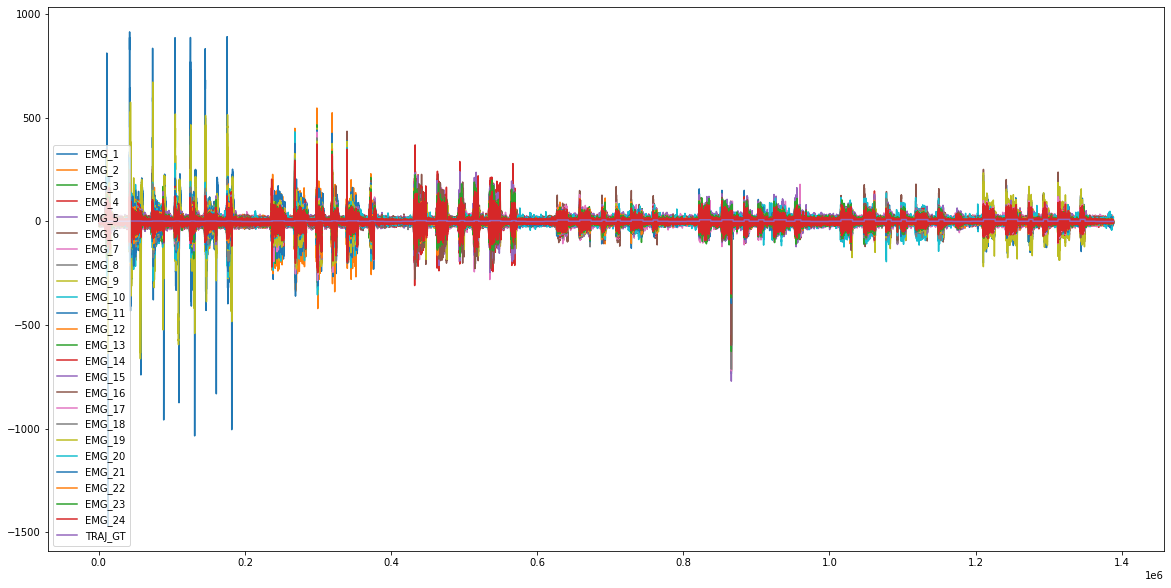

In [33]:
EMG_Frame.plot(figsize=(20,10))

In [34]:
bu.apply_filter(MovesFrame)

Processing channel:  EMG_1 EMG_2 EMG_3 EMG_4 EMG_5 EMG_6 EMG_7 EMG_8 EMG_9 EMG_10 EMG_11 EMG_12 EMG_13 EMG_14 EMG_15 EMG_16 EMG_17 EMG_18 EMG_19 EMG_20 EMG_21 EMG_22 EMG_23 EMG_24
Elapsed time: 677.13s


In [35]:
EMG_Frame_filetered = MovesFrame[ clmns ]

## Повний фільтрований набір даних

In [6]:
EMG_Frame_filetered.index = MovesFrame.index

In [11]:
EMG_Frame_filetered

EMG_1      EMG_2      EMG_3      EMG_4      EMG_5      EMG_6  \
-0.026817    -0.261862   0.303123  -0.202734  -1.943843  -1.389427  -0.669494   
-0.026622     7.046308   6.952308   6.860776   5.005369   6.592481   3.609495   
-0.026427    13.047385  12.364007  12.597996  10.304002  12.965083   7.321107   
-0.026232    16.568777  15.400809  15.831508  12.633554  16.353057   9.748169   
-0.026036    16.836411  15.282622  15.794964  11.334162  15.932831  10.106124   
...                ...        ...        ...        ...        ...        ...   
 270.955541  -2.105566  -3.148363  -3.005177  -2.143961  -1.608713  -1.027481   
 270.955736  -1.813001  -2.884598  -3.017213  -2.091459  -1.622557  -1.145980   
 270.955931  -1.463806  -2.355830  -2.601514  -1.827491  -1.398337  -1.124076   
 270.956126  -1.048625  -1.564326  -1.699512  -1.287295  -0.865211  -0.876504   
 270.956321  -0.584274  -0.604473  -0.473184  -0.548552  -0.110727  -0.453889   

                 EMG_7      EMG_8      EMG_9     EMG_10  ...     EMG_16  \
-0.026817     0.175058  -0.058520   0.002537   0.430727  ...  -0.528321   
-0.026622     7.058320   6.408080   5.668640   7.033514  ...   6.384795   
-0.026427    12.772447  11.642488  10.326872  12.383399  ...  11.921669   
-0.026232    16.167765  14.527385  13.089401  15.385229  ...  14.937869   
-0.026036    16.339546  14.315705  13.386738  15.369432  ...  14.818789   
...                ...        ...        ...        ...  ...        ...   
 270.955541  -0.576432  -0.171633  -0.861293  -2.473857  ...   0.590253   
 270.955736  -0.423549  -0.363884  -0.478897  -2.072985  ...   0.600566   
 270.955931  -0.306655  -0.439295  -0.295342  -1.625939  ...   0.554528   
 270.956126  -0.208435  -0.252556  -0.300829  -1.136607  ...   0.460555   
 270.956321  -0.108241   0.146948  -0.416749  -0.618234  ...   0.339725   

               EMG_17    EMG_18    EMG_19    EMG_20    EMG_21    EMG_22  \
-0.026817   -0.018326 -0.006267  0.559052  0.343673  0.614315  0.570240   
-0.026622    2.756636  3.043634  3.878519  3.290469  3.566859  3.067954   
-0.026427    4.870310  5.478050  6.619093  5.686536  6.089034  5.006075   
-0.026232    5.780501  6.756790  8.263601  7.044835  7.731800  5.919486   
-0.026036    5.223248  6.545402  8.484263  7.053069  8.105016  5.565283   
...               ...       ...       ...       ...       ...       ...   
 270.955541 -0.829741 -1.804169 -0.836683  0.260602  2.349945  1.663735   
 270.955736 -1.014485 -1.721012 -0.722269  0.259555  2.145372  1.603209   
 270.955931 -1.066491 -1.562033 -0.580575  0.235677  1.759571  1.469129   
 270.956126 -0.879996 -1.250864 -0.413129  0.288969  1.226785  1.242126   
 270.956321 -0.509222 -0.818560 -0.230565  0.425799  0.613175  0.951284   

               EMG_23    EMG_24  TRAJ_GT  
-0.026817   -0.006954 -0.060042     -1.0  
-0.026622    2.686178  2.616397     -1.0  
-0.026427    4.824347  4.826490     -1.0  
-0.026232    5.926906  6.160441     -1.0  
-0.026036    5.711449  6.341071     -1.0  
...               ...       ...      ...  
 270.955541 -0.576564 -0.850351     -1.0  
 270.955736 -0.441190 -0.809122     -1.0  
 270.955931 -0.163815 -0.752126     -1.0  
 270.956126  0.205916 -0.593260     -1.0  
 270.956321  0.618083 -0.341422     -1.0  

[1388544 rows x 25 columns]

In [78]:
EMG_Frame_filetered.loc[p + x*k : p + (x+1)*k].plot(figsize=(20,10))

<AxesSubplot:>

In [5]:
splits = EMG_Frame_filetered[EMG_Frame_filetered['TRAJ_GT'] != EMG_Frame_filetered['TRAJ_GT'].shift(1)].index

In [45]:
25804 / 5120

5.03984375

## Екстракція властивостей за допомогою функцій PutEMG. Дуже довго - 9 - 10 годин. Найдовші властивості: ApEn, SampleEn, BC, PSDFD

In [40]:
# EMG_features: pd.DataFrame = putemg_features.features_from_xml('./putemg_features/all_features.xml',
#                                                                './emg_gestures-03-repeats_short-2018-05-11-11-15-21-403-filtered.hdf5')

Calculating feature IAV: 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
Elapsed time: 1.17s
Calculating feature AAC: 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
Elapsed time: 1.22s
Calculating feature ApEn: 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
Elapsed time: 5873.04s
Calculating feature AR: 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
Elapsed time: 7.88s
Calculating feature CC: 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
Elapsed time: 8.91s
Calculating feature DASDV: 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
Elapsed time: 0.97s
Calculating feature Kurt: 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
Elapsed time: 3.07s
Calculating feature LOG: 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
Elapsed time: 1.20s
Calculating feature MAV1: 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
Elapsed time: 0.88s
Calculating feature MA

In [74]:
EMG_features.to_hdf('./emg_gestures-03-repeats_short-2018-05-11-11-15-21-403_filtered_features.hdf5',
                      'data', format='table', mode='w', complevel=5)

/home/master/miniconda3/lib/python3.8/site-packages/tables/file.py:426: UserWarning: a closed node found in the registry: ``/data/meta/values_block_1/meta/_i_table``
  warnings.warn("a closed node found in the registry: "


In [49]:
EMG_features = pd.read_hdf('./emg_gestures-03-repeats_short-2018-05-11-11-15-21-403_filtered_features.hdf5')

In [50]:
EMG_features

IAV_1         IAV_2         IAV_3         IAV_4  \
0.460879    10998.621105   9731.752305  10506.296001  13399.861323   
0.704824    11010.085484   9616.086263  10118.351316  11858.935467   
0.948770    10851.711653   9243.956940   9571.646298  11781.220588   
1.192716    11411.994233  10047.908726  11113.968722  13162.275090   
1.436661    11716.942426  10555.178862  12011.381083  13174.966206   
...                  ...           ...           ...           ...   
269.776796   6765.562459   6700.018584   6970.764549  12514.497450   
270.020741   7188.985871   7127.831491   7140.838985  11832.145732   
270.264687   9497.238215   9370.953482   9486.011599  13077.750475   
270.508633  10922.339334  10865.562109  10658.125834  13102.835866   
270.752578  10688.686054  10519.520252  10174.972036  12355.707771   

                   IAV_5         IAV_6         IAV_7         IAV_8  \
0.460879    13518.582159  10751.520738  11279.973841  10611.711590   
0.704824    12293.557830  10391.574873  11247.652405  10653.214707   
0.948770    11988.014387  10090.951341  10531.753625  10283.186944   
1.192716    13061.276624  10495.350974  11107.292738  10608.212504   
1.436661    12979.045955  10898.942307  12540.299515  11587.031450   
...                  ...           ...           ...           ...   
269.776796  11031.904765   8580.814118  10883.292376   7482.121670   
270.020741  10794.449994   8336.495102  10328.116779   7452.173451   
270.264687  12282.276220   9174.685409  11912.871200   9413.873661   
270.508633  12268.859346   9136.899063  12031.133927  10523.440492   
270.752578  11401.084617   9504.251512  12389.080207  10739.564318   

                  IAV_9        IAV_10  ...  PSDFD_22  PSDFD_23  PSDFD_24  \
0.460879    7640.657718   8618.555040  ...  0.937853  0.937546  0.937853   
0.704824    7595.623354   8565.200548  ...  0.938159  0.937853  0.937853   
0.948770    7461.928608   8317.260376  ...  0.938617  0.937853  0.937853   
1.192716    8005.602588   8872.632846  ...  0.937853  0.937546  0.937853   
1.436661    8419.708706   9198.248030  ...  0.939225  0.938463  0.938617   
...                 ...           ...  ...       ...       ...       ...   
269.776796  5550.762855   5694.733827  ...  0.937546  0.937546  0.937546   
270.020741  5961.779468   6125.798169  ...  0.937546  0.938159  0.938159   
270.264687  7766.784906   8481.756669  ...  0.939983  0.940586  0.940586   
270.508633  9082.530328  10122.534221  ...  0.941339  0.943437  0.942692   
270.752578  8920.938903   9810.927300  ...  0.941944  0.942692  0.942393   

            TRAJ_GT  VIDEO_STAMP  subject               date_time  \
0.460879       -1.0    -1.156186      3.0 2018-05-11 11:15:21.403   
0.704824       -1.0    -0.912240      3.0 2018-05-11 11:15:21.403   
0.948770       -1.0    -0.668295      3.0 2018-05-11 11:15:21.403   
1.192716       -1.0    -0.424349      3.0 2018-05-11 11:15:21.403   
1.436661       -1.0    -0.180404      3.0 2018-05-11 11:15:21.403   
...             ...          ...      ...                     ...   
269.776796     -1.0   268.159731      3.0 2018-05-11 11:15:21.403   
270.020741     -1.0   268.403676      3.0 2018-05-11 11:15:21.403   
270.264687     -1.0   268.647622      3.0 2018-05-11 11:15:21.403   
270.508633     -1.0   268.891568      3.0 2018-05-11 11:15:21.403   
270.752578     -1.0   269.135513      3.0 2018-05-11 11:15:21.403   

                    type  TRAJ_1     trajectory  
0.460879    emg_gestures    -1.0  repeats_short  
0.704824    emg_gestures    -1.0  repeats_short  
0.948770    emg_gestures    -1.0  repeats_short  
1.192716    emg_gestures    -1.0  repeats_short  
1.436661    emg_gestures    -1.0  repeats_short  
...                  ...     ...            ...  
269.776796  emg_gestures    -1.0  repeats_short  
270.020741  emg_gestures    -1.0  repeats_short  
270.264687  emg_gestures    -1.0  repeats_short  
270.508633  emg_gestures    -1.0  repeats_short  
270.752578  emg_gestures    -1.0  repeats_sho

In [4]:
EMG_features['TRAJ_GT'].unique()

array([-1.,  0.,  1.,  2.,  3.,  6.,  7.,  8.,  9.])

### Елементи бробки сигналів засобами PutEMG

In [97]:
all_feature_records = [bu.Record(os.path.basename('./emg_gestures-03-repeats_short-2018-05-11-11-15-21-403_filtered_features.hdf5'))]

In [98]:
all_feature_records

[emg_gestures-03-repeats_short-2018-05-11-11-15-21-403]

In [99]:
records_filtered_by_subject = bu.record_filter(all_feature_records)

In [100]:
records_filtered_by_subject

[emg_gestures-03-repeats_short-2018-05-11-11-15-21-403]

Вибір значень певних ознак

In [110]:
data = bu.prepare_data({records_filtered_by_subject[0]: EMG_features},
             {'Shit': records_filtered_by_subject},
             ["AAC"], 
             list(gestures.keys()))

In [113]:
data['Shit']['output_0'].unique()

array([0., 1., 2., 3., 6., 7., 8., 9.])

In [109]:
put_prepared = data['Shit']
put_prepared[put_prepared.columns[put_prepared.columns.str.contains('input')]].plot(figsize=(20,10))

<AxesSubplot:>

In [45]:
gestures = {
        0: "Idle",
        1: "Fist",
        2: "Flexion",
        3: "Extension",
        6: "Pinch index",
        7: "Pinch middle",
        8: "Pinch ring",
        9: "Pinch small"
    }
channel_range = {
        "24chn": {"begin": 1, "end": 24},
    }

In [ ]:
data = bu.prepare_data(dfs, s, features, list(gestures.keys()))

## Розрідження даних

In [9]:
EMG_croped = EMG_Frame.apply(lambda x: x.abs()) 
#  DataFrame.clip(lower=None, upper=None, axis=None, *args, **kwargs) Trim values at input threshold(s).

In [10]:
EMG_croped.mode()

EMG_1       EMG_2       EMG_3       EMG_4         EMG_5  \
0          0.000006    0.000012    0.000017    0.000003  3.881169e-07   
1          0.000006    0.000019    0.000022    0.000017  1.555439e-06   
2          0.000012    0.000021    0.000035    0.000017  4.641914e-06   
3          0.000014    0.000028    0.000035    0.000020  6.120538e-06   
4          0.000023    0.000032    0.000042    0.000024  8.053338e-06   
...             ...         ...         ...         ...           ...   
1388539  302.157874  394.181750  250.982794  245.394070  2.492620e+02   
1388540  303.689961  398.254536  272.957744  278.149020  2.989796e+02   
1388541  377.599133  406.061118  384.631098  381.373313  3.974758e+02   
1388542  418.465149  414.889210  400.105295  403.986296  4.310835e+02   
1388543  450.581238  446.260837  443.602135  444.112097  4.693794e+02   

              EMG_6       EMG_7       EMG_8       EMG_9        EMG_10  ...  \
0          0.000003    0.000001    0.000006    0.000004  8.300614e-07  ...   
1          0.000003    0.000018    0.000008    0.000004  7.793592e-06  ...   
2          0.000010    0.000019    0.000015    0.000018  7.850648e-06  ...   
3          0.000015    0.000026    0.000018    0.000019  8.578372e-06  ...   
4          0.000028    0.000030    0.000021    0.000020  9.817512e-06  ...   
...             ...         ...         ...         ...           ...  ...   
1388539  205.805287  271.067898  233.634563  260.898783  2.796738e+02  ...   
1388540  226.755964  275.221997  275.082122  262.582828  2.848460e+02  ...   
1388541  310.498740  390.365110  371.413516  268.999656  3.191490e+02  ...   
1388542  327.797279  401.154516  398.803508  298.051088  3.535272e+02  ...   
1388543  361.695639  447.102170  436.544108  320.956732  3.803454e+02  ...   

             EMG_16      EMG_17      EMG_18        EMG_19      EMG_20  \
0          0.000004    0.000002    0.000021  8.633700e-07    0.000006   
1          0.000017    0.000002    0.000022  5.417961e-06    0.000006   
2          0.000021    0.000003    0.000025  1.042940e-05    0.000008   
3          0.000028    0.000013    0.000028  1.080382e-05    0.000009   
4          0.000034    0.000014    0.000029  1.570888e-05    0.000011   
...             ...         ...         ...           ...         ...   
1388539  264.463031  242.031728  184.344145  1.984686e+02  142.678684   
1388540  266.992576  248.906753  184.737150  1.991592e+02  149.101900   
1388541  303.137191  260.773883  202.912711  2.033040e+02  196.840279   
1388542  348.007498  263.096987  221.996984  2.057039e+02  206.074649   
1388543  368.291216  267.441729  239.858475  2.273129e+02  224.672662   

               EMG_21      EMG_22        EMG_23      EMG_24  TRAJ_GT  
0        8.090565e-07    0.000010  2.787239e-07    0.000002      0.0  
1        1.641724e-05    0.000016  1.064540e-06    0.000009      NaN  
2        2.086968e-05    0.000018  3.065024e-06    0.000015      NaN  
3        2.485047e-05    0.000019  1.068818e-05    0.000015      NaN  
4        2.642759e-05    0.000020  1.129035e-05    0.000017      NaN  
...               ...         ...           ...         ...      ...  
1388539  1.436631e+02  158.264856  2.076389e+02  192.258236      NaN  
1388540  1.824384e+02  158.762746  2.093515e+02  195.420719      NaN  
1388541  2.162518e+02  185.595263  2.119540e+02  199.441946      NaN  
1388542  2.407463e+02  206.597376  2.288416e+02  207.842985      NaN  
1388543  2.542129e+02  217.362600  2.390564e+02  222.420293      NaN  

[1388544 rows x 25 columns]

Обрізка ділянок спокою кінцівки

In [12]:
EMG_croped[EMG_croped <= 40.] = 0

In [13]:
EMG_croped['TRAJ_GT'] = EMG_Frame['TRAJ_GT']

In [14]:
EMG_croped.plot(figsize=(20,10))

<AxesSubplot:>

## Завантаження зображень рухів

In [19]:
img0 = pimg.imread('./putEMG/0_idle.jpg')
img1 = pimg.imread('./putEMG/1_fist.jpg')
img2 = pimg.imread('./putEMG/2_flexion.jpg')
img3 = pimg.imread('./putEMG/3_extension.jpg')
img6 = pimg.imread('./putEMG/6_pinch-1-2.jpg')
img7 = pimg.imread('./putEMG/7_pinch-1-3.jpg')
img8 = pimg.imread('./putEMG/8_pinch-1-4.jpg')
img9 = pimg.imread('./putEMG/9_pinch-1-5.jpg')
plt.rcParams["figure.figsize"] = (10,10)

Мітка 0

In [20]:
plt.imshow(img0)

## Мітка 1

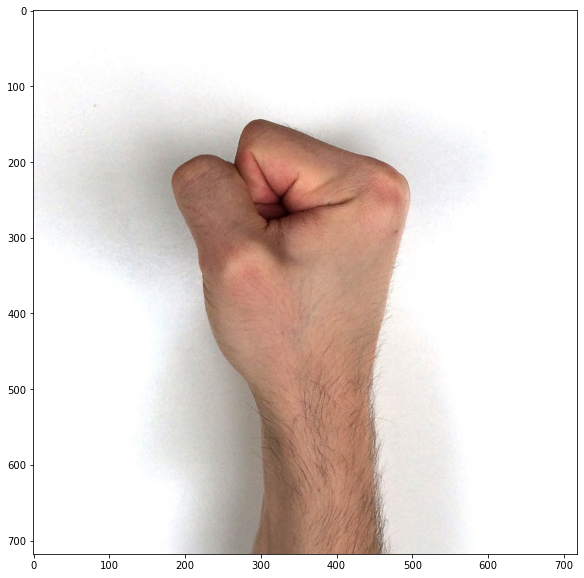

In [21]:
plt.imshow(img1)

На графіку маємо спочатку викид, пов'язаний з давільним рухом руки, а потім - 6 патернів стискання в кулак, що є семетричними за часом.

<AxesSubplot:>

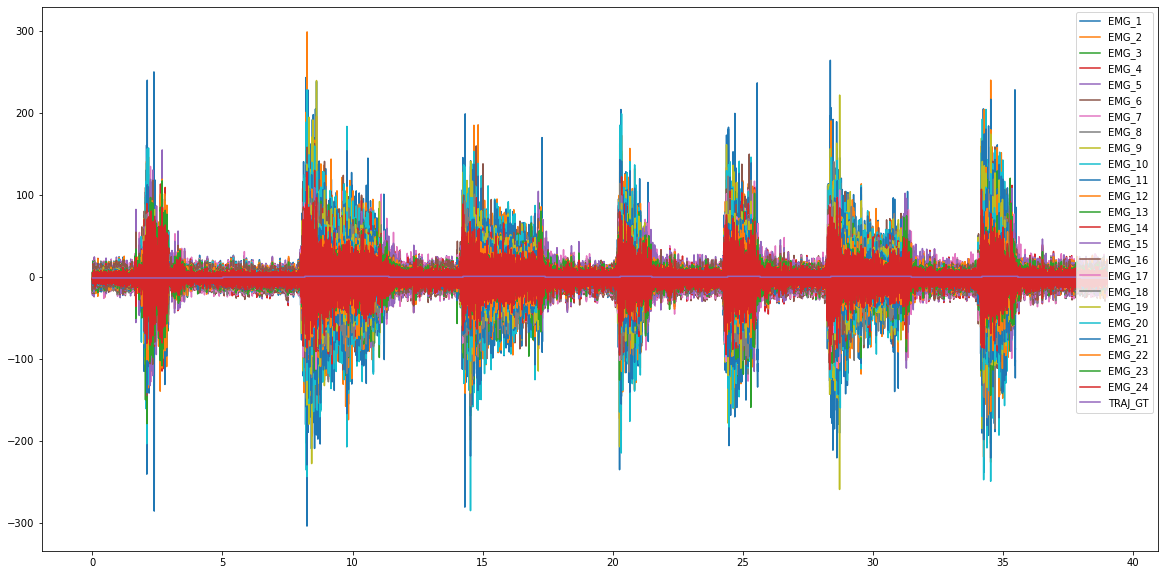

In [40]:
EMG_fists = EMG_Frame.loc[x*k:(x+1)*k]
EMG_fists.plot(figsize=(20,10))

<AxesSubplot:>

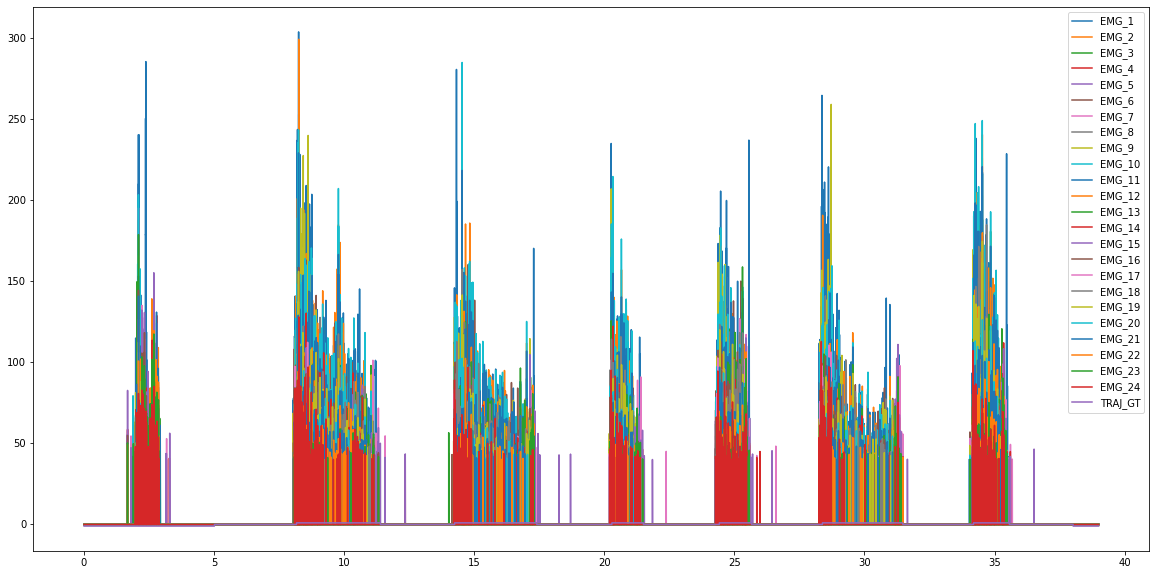

In [15]:
EMG_croped.loc[x*k:(x+1)*k].plot(figsize=(20,10))

Докладний розгляд кожного повторення руху "Кулак"

## Мітка 2

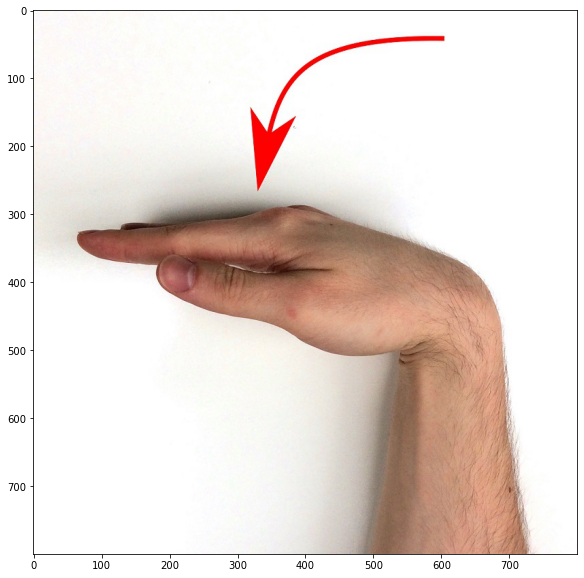

In [22]:
plt.imshow(img2)

<AxesSubplot:>

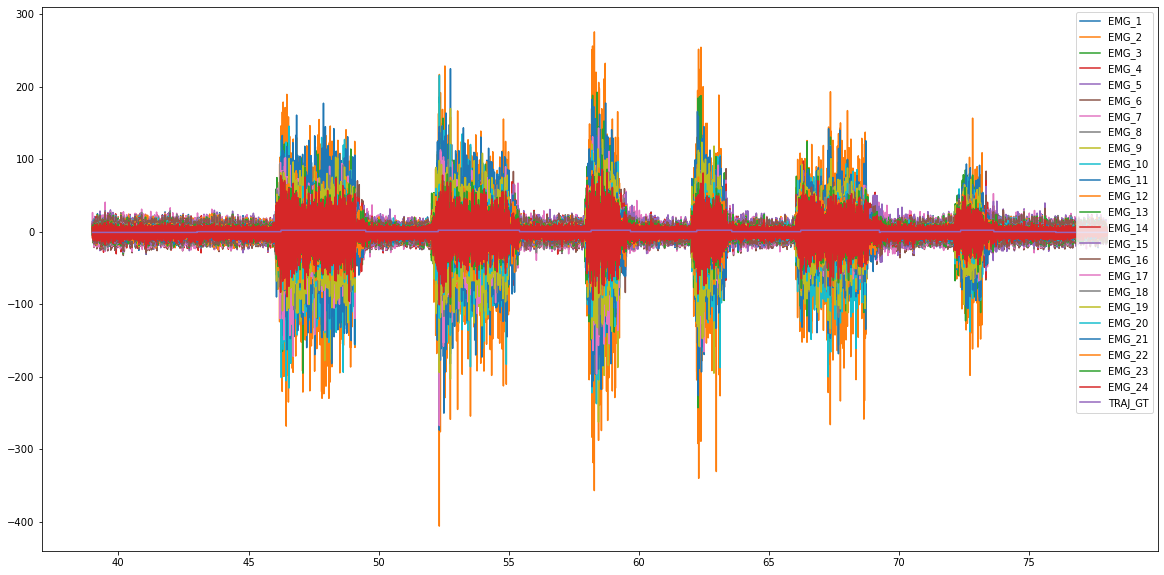

In [41]:
x=1
EMG_Frame.loc[x*k:(x+1)*k].plot(figsize=(20,10))

<AxesSubplot:>

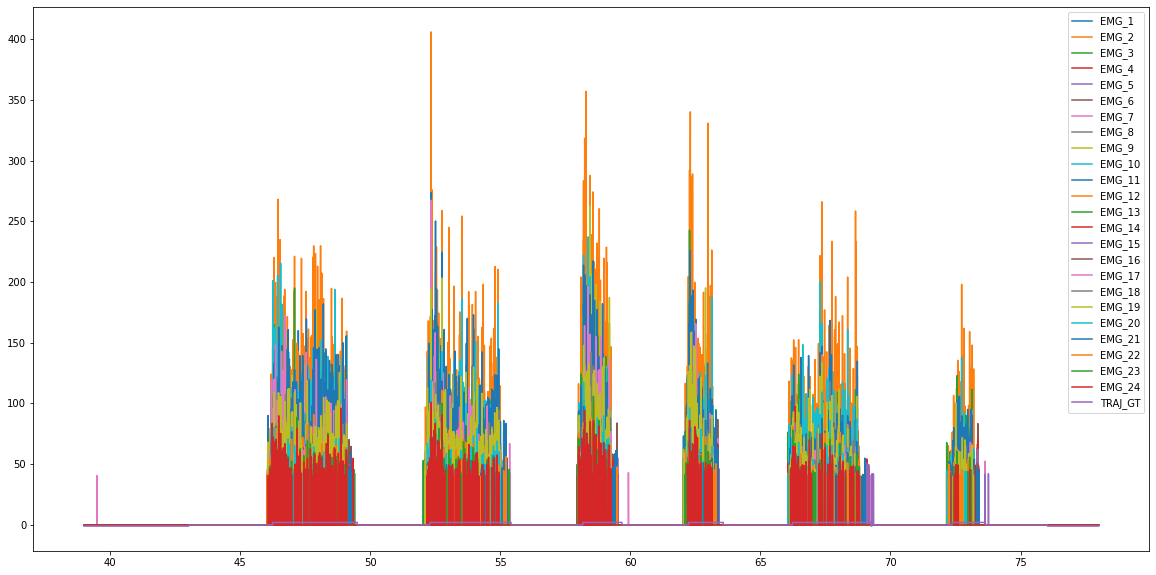

In [16]:
x=1
EMG_croped.loc[x*k:(x+1)*k].plot(figsize=(20,10))

Мітка 3

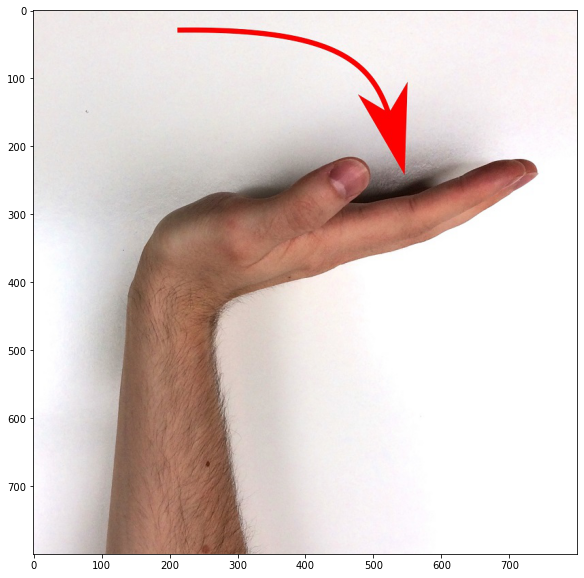

In [24]:
plt.imshow(img3)

<AxesSubplot:>

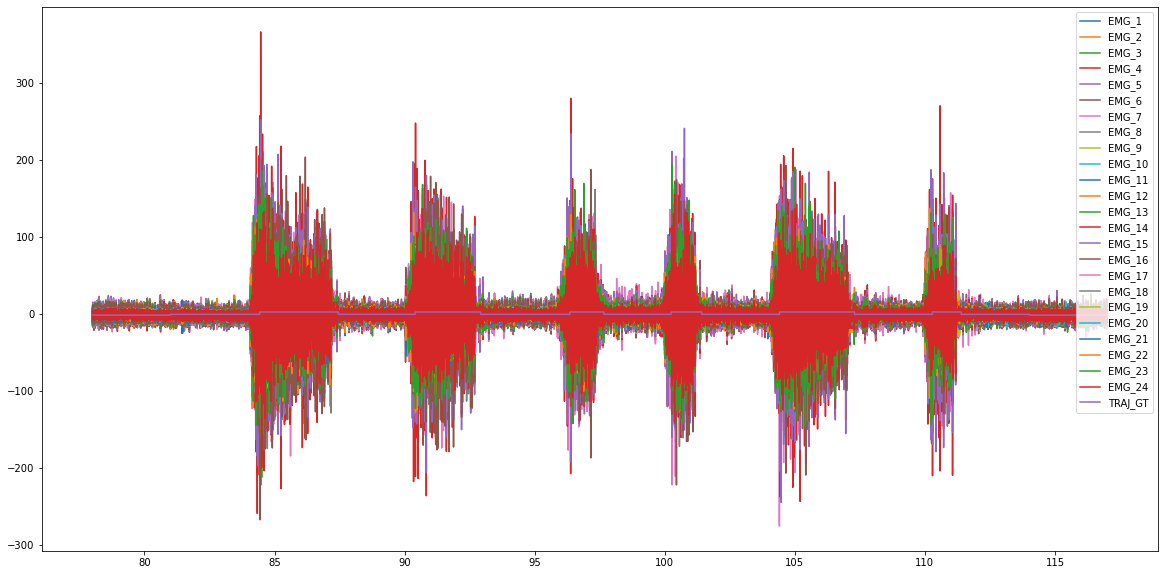

In [42]:
x=2
EMG_Frame.loc[x*k:(x+1)*k].plot(figsize=(20,10))

<AxesSubplot:>

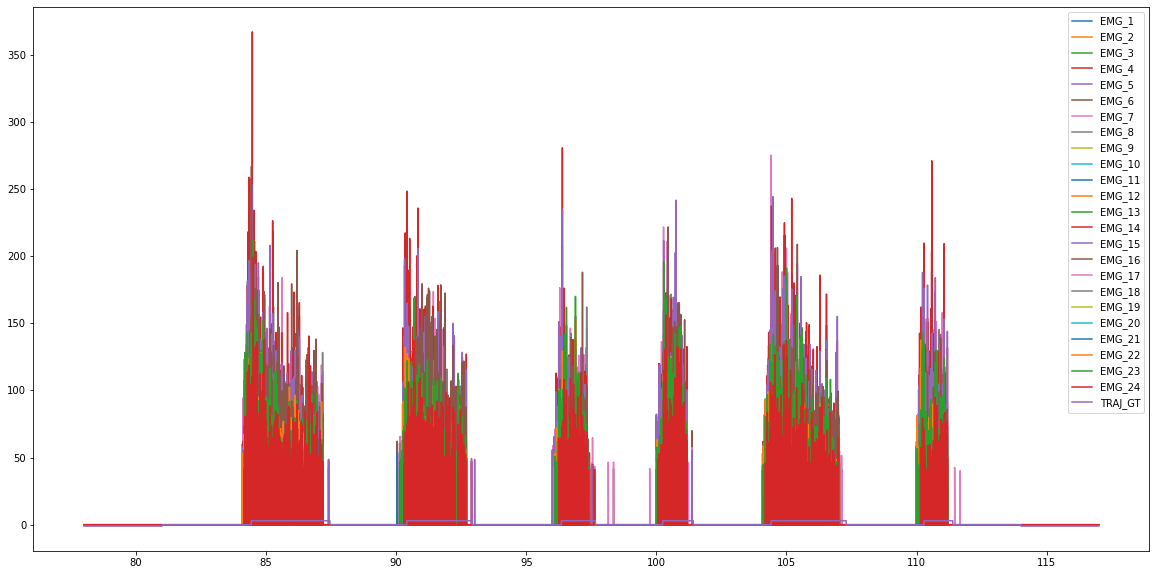

In [17]:
x=2
EMG_croped.loc[x*k:(x+1)*k].plot(figsize=(20,10))

Мітка 6

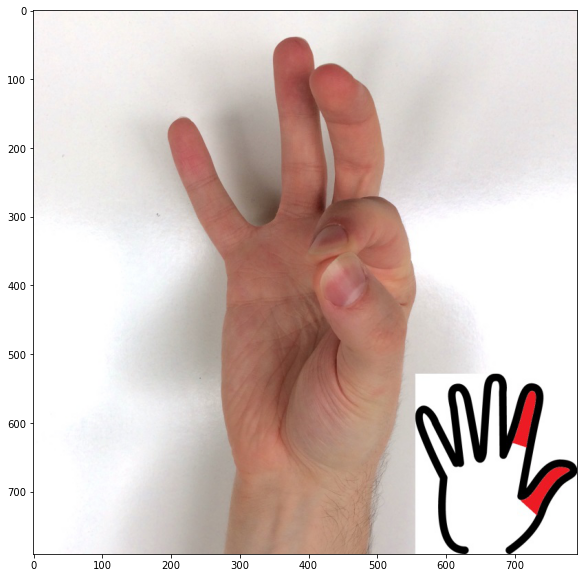

In [25]:
plt.imshow(img6)

In [43]:
x=3
EMG_Frame.loc[x*k:(x+1)*k].plot(figsize=(20,10))

<AxesSubplot:>

In [18]:
x=3
EMG_croped.loc[x*k:(x+1)*k].plot(figsize=(20,10))

<AxesSubplot:>

Мітка 7

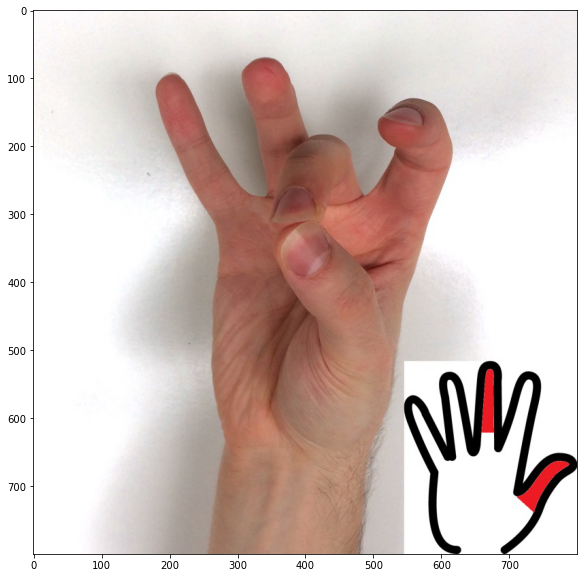

In [26]:
plt.imshow(img7)

<AxesSubplot:>

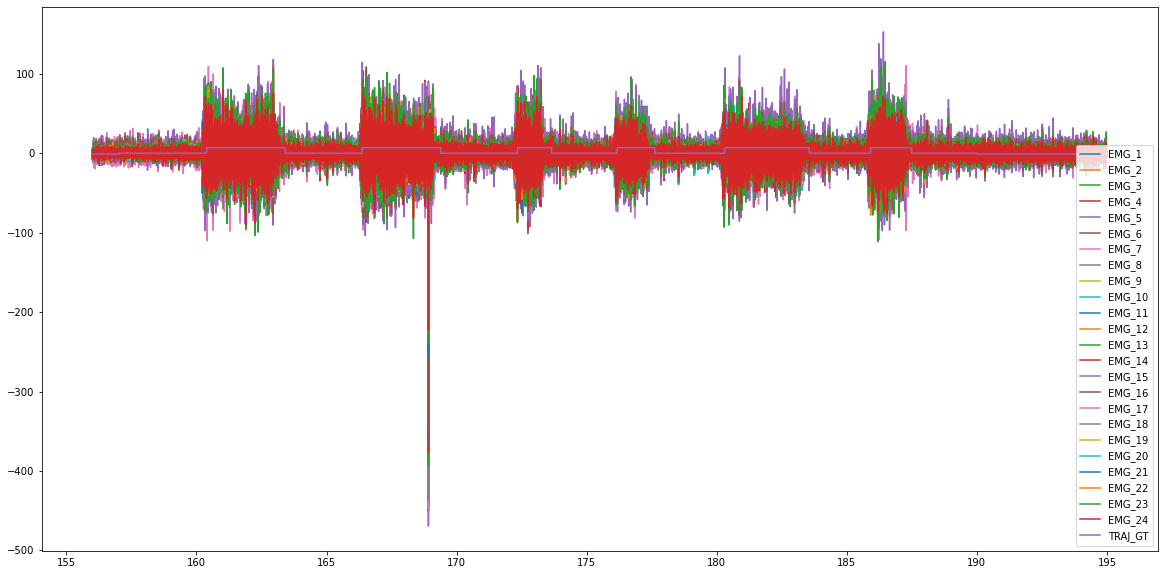

In [44]:
x=4
EMG_Frame.loc[x*k:(x+1)*k].plot(figsize=(20,10))

<AxesSubplot:>

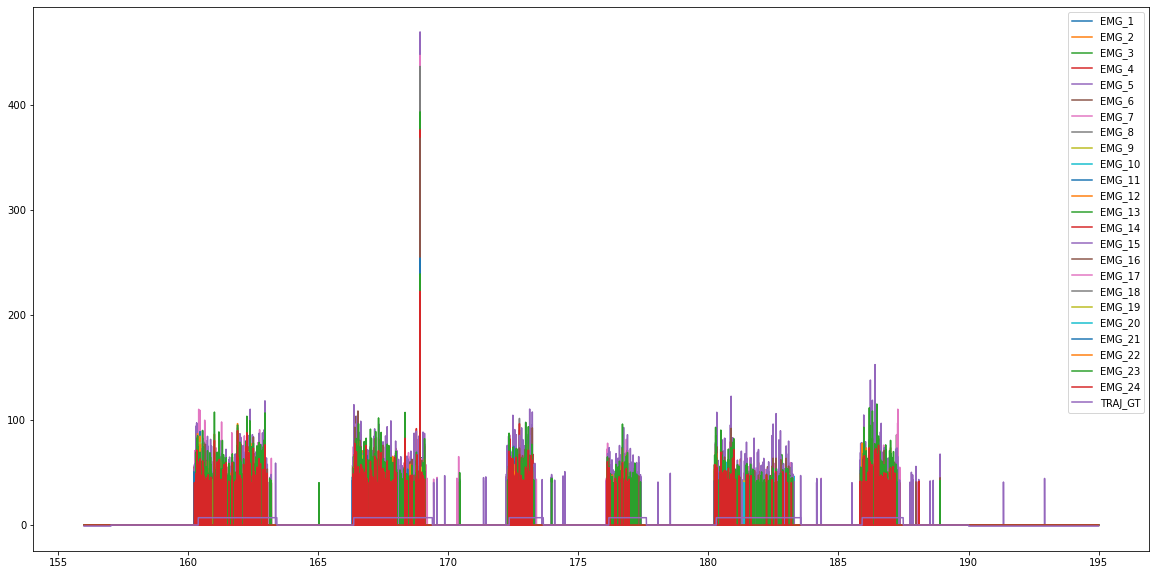

In [19]:
x=4
EMG_croped.loc[x*k:(x+1)*k].plot(figsize=(20,10))

Мітка 8

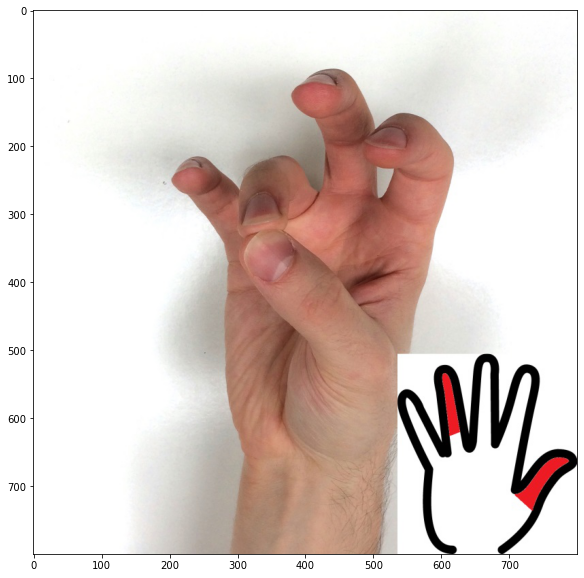

In [27]:
plt.imshow(img8)

<AxesSubplot:>

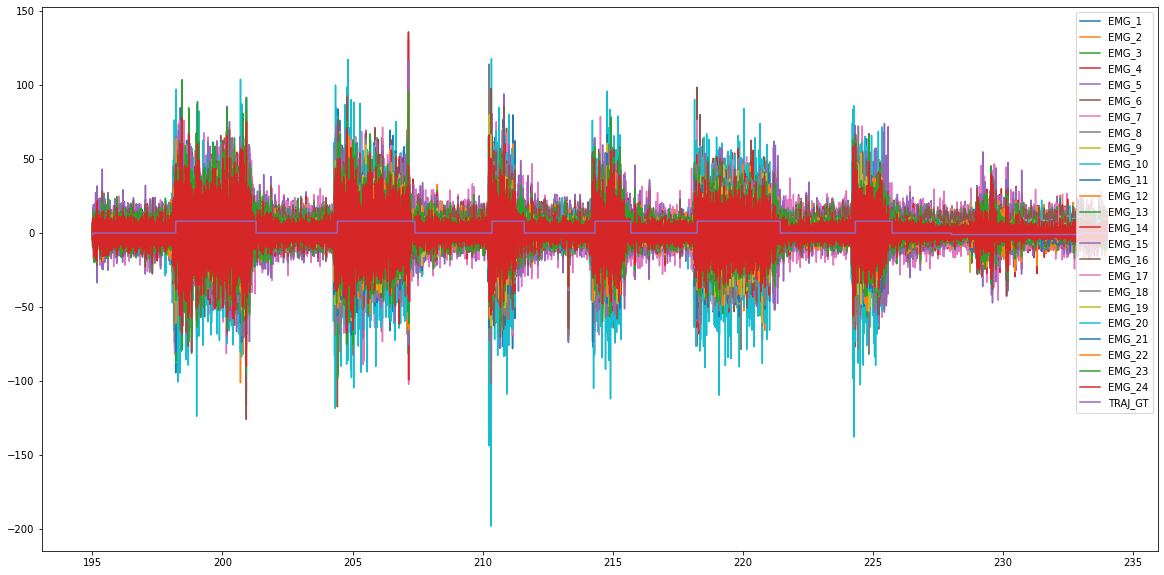

In [45]:
x=5
EMG_Frame.loc[x*k:(x+1)*k].plot(figsize=(20,10))

In [20]:
x=5
EMG_croped.loc[x*k:(x+1)*k].plot(figsize=(20,10))

<AxesSubplot:>

Мітка 9

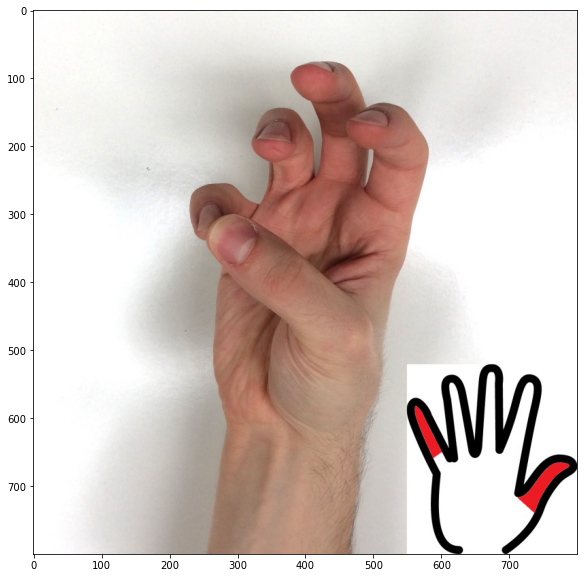

In [28]:
plt.imshow(img9)

In [46]:
x=6
EMG_Frame.loc[x*k:(x+1)*k].plot(figsize=(20,10))

<AxesSubplot:>

<AxesSubplot:>

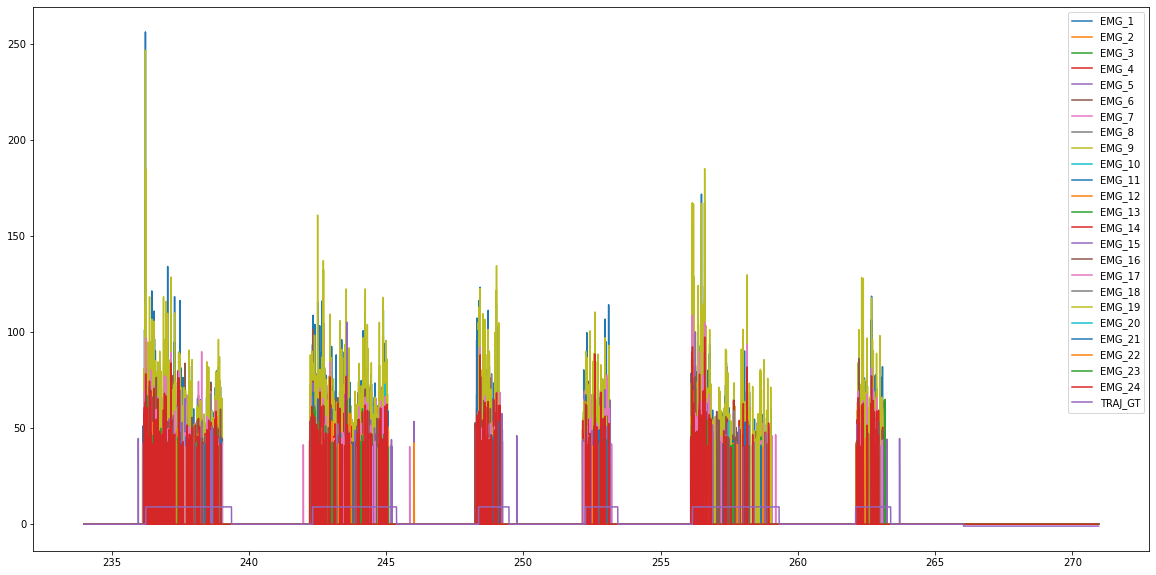

In [21]:
x=6
EMG_croped.loc[x*k:(x+1)*k].plot(figsize=(20,10))

In [24]:
MovesFrame.head()

EMG_1  EMG_2  EMG_3  EMG_4  EMG_5  EMG_6  EMG_7  EMG_8  EMG_9  EMG_10  ...  \
0    4.0    5.0    4.0    3.0    2.0    4.0    4.0    4.0    2.0     4.0  ...   
1    6.0    6.0    7.0    7.0    6.0    5.0    6.0    6.0    4.0     5.0  ...   
2   14.0   14.0   14.0   13.0   14.0   10.0   14.0   13.0   10.0    13.0  ...   
3   21.0   20.0   20.0   18.0   20.0   14.0   20.0   19.0   15.0    20.0  ...   
4   21.0   21.0   21.0   17.0   21.0   16.0   22.0   20.0   16.0    20.0  ...   

   EMG_23  EMG_24  TRAJ_1          type  subject     trajectory  \
0     4.0     4.0    -1.0  emg_gestures      3.0  repeats_short   
1     4.0     5.0    -1.0  emg_gestures      3.0  repeats_short   
2     8.0     8.0    -1.0  emg_gestures      3.0  repeats_short   
3    10.0    10.0    -1.0  emg_gestures      3.0  repeats_short   
4    10.0    10.0    -1.0  emg_gestures      3.0  repeats_short   

                date_time  TRAJ_GT_NO_FILTER  VIDEO_STAMP  TRAJ_GT  
0 2018-05-11 11:15:21.403               -1.0    -1.643882     -1.0  
1 2018-05-11 11:15:21.403               -1.0    -1.643687     -1.0  
2 2018-05-11 11:15:21.403               -1.0    -1.643492     -1.0  
3 2018-05-11 11:15:21.403               -1.0    -1.643297     -1.0  
4 2018-05-11 11:15:21.403               -1.0    -1.643101     -1.0  

[5 rows x 32 columns]

### Excluding force sensors

In [17]:
EMGFrame = MovesFrame[MovesFrame.columns[~MovesFrame.columns.str.contains('FORCE')]]

In [2]:
FistFrame = pd.read_hdf('./gestures_r_short_sampled/1_fist.hdf5')

In [4]:
FistFrame[FistFrame.columns[FistFrame.columns.str.contains('EMG')]]

EMG_1      EMG_2      EMG_3      EMG_4      EMG_5  \
intrvl                                                                    
0      8.165461    6.034196 -18.758296 -16.046698 -11.602283  -0.654039   
       8.165656  -11.529140 -24.371128 -21.855640 -16.753390  -5.562852   
       8.165851  -25.065813 -25.945584 -25.677532 -20.436565  -9.530794   
       8.166046  -33.256696 -22.961769 -26.538746 -21.801842 -11.750202   
       8.166241  -36.215740 -16.359353 -24.292376 -20.627644 -11.973730   
...                     ...        ...        ...        ...        ...   
518    31.795835   1.957665   0.852445   0.606604  -1.526187  -1.996645   
       31.796030   2.751075   1.560455   1.383163  -0.734505  -0.634427   
       31.796225   3.889503   2.819949   2.492035   0.517961   1.053009   
       31.796420   5.216483   4.368489   3.748423   2.071202   2.710476   
       31.796615   6.569985   5.850573   5.006681   3.729195   4.110728   

                      EMG_6      EMG_7      EMG_8      EMG_9     EMG_10  ...  \
intrvl                                                                   ...   
0      8.165461    1.641798  11.502995   7.487499  19.883410 -44.056613  ...   
       8.165656   -3.627089   4.837598  -2.013682   7.569439 -47.167468  ...   
       8.165851   -8.478975  -1.631992  -9.970506  -2.199985 -48.063757  ...   
       8.166046  -11.891027  -6.896841 -15.319541  -8.850772 -45.135478  ...   
       8.166241  -13.371598 -10.403952 -18.014297 -12.659979 -38.018978  ...   
...                     ...        ...        ...        ...        ...  ...   
518    31.795835  -4.297649   5.255992   7.217033   4.519875  -0.544323  ...   
       31.796030  -3.711259   4.583594   7.452924   4.979168  -0.164438  ...   
       31.796225  -2.443905   4.745358   7.967969   5.861037   0.577024  ...   
       31.796420  -0.717308   5.308442   8.645060   7.022519   1.602701  ...   
       31.796615   1.152357   5.838467   9.326018   8.213538   2.734376  ...   

                     EMG_15     EMG_16     EMG_17     EMG_18     EMG_19  \
intrvl                                                                    
0      8.165461    8.297190  20.026423  25.150762  12.106578 -10.839250   
       8.165656    0.042751   8.607229  13.878046   4.371791 -13.435947   
       8.165851   -7.479557  -0.486431   5.022079  -1.815933 -15.520428   
       8.166046  -13.205583  -6.301376  -0.308341  -5.077919 -15.984901   
       8.166241  -16.680537  -8.987001  -2.093501  -5.058920 -14.335466   
...                     ...        ...        ...        ...        ...   
518    31.795835   5.677027   2.720337  -1.308346  -0.004541   2.263024   
       31.796030   5.893777   4.252779  -0.294307   0.826689   3.302327   
       31.796225   6.464998   6.354668   0.736445   1.810062   4.358599   
       31.796420   7.264821   8.605357   1.676084   2.812640   5.263758   
       31.796615   8.158849  10.591185   2.467181   3.706477   5.932017   

                     EMG_20     EMG_21     EMG_22     EMG_23     EMG_24  
intrvl                                                                   
0      8.165461  -11.629144  -5.319509   6.878781  12.765342  14.976473  
       8.165656  -15.017328  -9.622594   1.076408   3.525745   2.296156  
       8.165851  -18.142901 -13.426776  -4.368797  -5.476814  -9.158320  
       8.166046  -19.914961 -15.449450  -8.298118 -12.962350 -18.264061  
       8.166241  -19.615271 -14.983191 -10.066652 -18.141698 -24.498900  
...                     ...        ...        ...        ...        ...  
518    31.795835   2.549342   5.101587  14.279874  15.615765   5.024568  
       31.796030   3.224332   6.026734  13.558553  17.481127   9.452214  
       31.796225   3.981990   7.150391  12.822864  19.155091  13.716662  
       31.796420   4.788534   8.255601  12.044648  20.175031  17.206452  
       31.796615   5.619121   9.130996  11.183872  20.278598  19.528187  

[5763248 rows x 24 columns]

In [4]:
n_smpl = FistFrame.index.levels[0].to_numpy()
max_len = 0
max_x = 0
for x in n_smpl:
    lng = FistFrame.loc[x].shape[0]
    if lng > max_len:
        max_len = lng
        max_x = x
del n_smpl

In [5]:
(max_len, max_x)

(25303, 197)

In [6]:
FistArray = FistFrame.loc[0].to_numpy().copy()

In [7]:
FistArray = np.array([np.pad(FistArray, ((0, max_len - FistArray.shape[0]), (0,0)),'edge')])

In [8]:
FistArray.shape

(1, 25303, 32)

In [10]:
level0 = FistFrame.index.levels[0][1:200].to_numpy().copy()

Доповнення патернів до максимальної довжини патерну

In [12]:
with open('./gestures_r_short_sampled/1_fist.npy', 'wb') as f:
    np.save(f, FistArray)

In [3]:
putemg_folder = "./putEMG/Data-HDF5/"
filtered_data_folder = "./gestures_repeats_short_filtered"
sampled_data_folder = "./gestures_r_short_sampled"

In [4]:
sampled_files = [f for f in sorted(glob.glob(os.path.join(sampled_data_folder, "[01236789]*.hdf5")))]

In [5]:
read_sampled_files = [f for f in sorted(glob.glob(os.path.join(sampled_data_folder, "[01236789]*.npy")))]

In [5]:
sampled_files[0]

'./gestures_r_short_sampled/0_idle.hdf5'

Edge - занадто підвищщує вплив останнього записаного значення сигналу для семплу, що виправдано логічно <br>
Mean - дорівнює 0 через взаємознижчення різними фазами коливань <br>
Середнє значення за амплітудою - дозволить впливати на значення середнього вектору виступаючим з більшості за довжиною частинам семплів

In [22]:
samplen = 36000

file = sampled_files[0]
Frame = pd.read_hdf(file)
Frame = Frame[Frame.columns[Frame.columns.str.contains('EMG')]].copy()
level0 = Frame.index.levels[0][0:200].to_numpy().copy()
print("Fitting the " + file + " file dataset")
for i in level0:
    temp = Frame.loc[i].to_numpy().copy()
    padded = np.pad(temp, ((0, samplen - temp.shape[0]), (0,0)), 'constant', constant_values=((0,np.abs(temp).mean(axis=0)),(0,0)))
    del temp
    if i == 0:
        SampleArray = np.array([padded])
    else:
        SampleArray = np.append(SampleArray, [padded], axis=0)
    del padded
del Frame
basename = os.path.basename(file)
filename = os.path.splitext(basename)[0]
output_file = filename +'.npy'
with open(os.path.join(sampled_data_folder, output_file), 'wb') as f:
    np.save(f, SampleArray)
del SampleArray

print(samplen)

Fitting the ./gestures_r_short_sampled/0_idle.hdf5 file dataset


/home/master/miniconda3/lib/python3.8/site-packages/numpy/lib/arraypad.py:490: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x = np.array(x)


36000


# Звіт:
- Зроблено датафрейми-файли.hdf5 семплів для всіх класів
- Зроблено нумпай-масиви-файли.npy семплів для всіх класів
- Заповнення семплів до однакової довжини значенням середньої амплітуди семплу
- Розпочато навчання за ознакою амплітуди
- Обчислювально спрощено контур оптимізації за полем контрольних допусків: змінення дельта без подадльших обислювань за умови нульвої відстані від центру базового контейнера базового класу до центру будь-якого якого іншого з вибірки

### Завантажимо масиви семплів різних жестів з файлів та покладемо їх адресси в список

### Вибірки слід формувати не більше ніж з 200 семплів

$ E^{0} = f(N,K_2,K_3),\ \ K_2 = k_2(R^0, [h^{0,1}_1, h^{0,1}_2, ... ]), \ \ K_3 = k_3(R^0, [h^{1,0}_1, h^{1,0}_2, ... ]) $</br>
$ h^{0,1}_n = h([bc^0_1, bc^0_2,\ ... ],\ [b^1_{1,n}, b^1_{2,n},\ ...]), \ \ h^{1,0}_n = h([bc^1_1, bc^1_2,\ ... ],\ [b^0_{1,n}, b^0_{2,n},\ ...]),$</br>
$ b^k_{i,n} = b(\delta_i, s^k_{i,n}) $</br>
Верхній індекс 0 - належність до базового класу </br>
$ E^{0} $ - інформаційний критерій </br>
$ K_2 $ - кількість власних реалізацій, що не потрапили в контейнер базового класу</br>
$ K_3 $ - кількість реалізацій найближчого класу сусіду, що потрапили в контейнер базового класу</br>
$ h^{0,1} $ - відстані Хемінга від центру базового до реалізацій найближчого сусіду </br>
$ h^{1,0} $ - відстані Хемінга від центру найближчого сусіду до реалізацій базового </br>
$ b^k_{i,n} $ - i-та координата бінеаризованої n-тої реалізації k-того класу </br>
$ s^k_{i,n} $ - i-та координата n-тої реалізації k-того класу з навчальної вибірки </br>
$ \delta_i $ - контрольний допуск на i-ту ознаку </br>
$ E^{0} = f(N,R^0,[h^{0,1}_1, h^{0,1}_2,\ ... ], [h^{1,0}_1, h^{1,0}_2,\ ... ]) $

### Реалізовано паралельну оптимізацію контрольних допусків, визначення параметрів контейнерів, що відділяють у гіперпросторі ознак реалізації відповідного класу від всіх інших, для кожного класу окремо: 

Передбачую, що $\delta$ має обиратися як $\frac 1 2\left(\max\limits_{i,j,k} {x_{i,j}} - \min\limits_{i,j,k} {x_{i,j}}\right) $ або як $\frac 1 2\left(\max\limits_{i,j,k} {x_{i,j}}\right)\ \ \ [ i=0 .. M, j=0 .. N]$

In [7]:
cont_deltas = []
bin_centers = []
cont_radiuses = []

Через неспівпадіння сигналів за фазою, побудування контейнерів класів буде призводитись на базі Амплітуди 

In [6]:
GestArrs = []
for file in read_sampled_files:
    temp = np.load(file, allow_pickle=True)
    GestArrs.append(temp)
    del temp

In [7]:
GestArrs[0].shape

(200, 36000, 24)

### Скорочення довжини семплів методом знаходження максимальної амплітуди кожних 36 вимірювань, для прискорення навчання:

In [26]:
shortGestArrs = np.array([np.abs(sample).reshape(200,-1,36,24).max(axis=2) for sample in GestArrs])

In [27]:
shortGestArrs.shape

(8, 200, 1000, 24)

In [58]:
delta = fistAr.max(axis=(0,1))

In [12]:
center = shortGestArrs[1].mean(axis=0)

<AxesSubplot:>

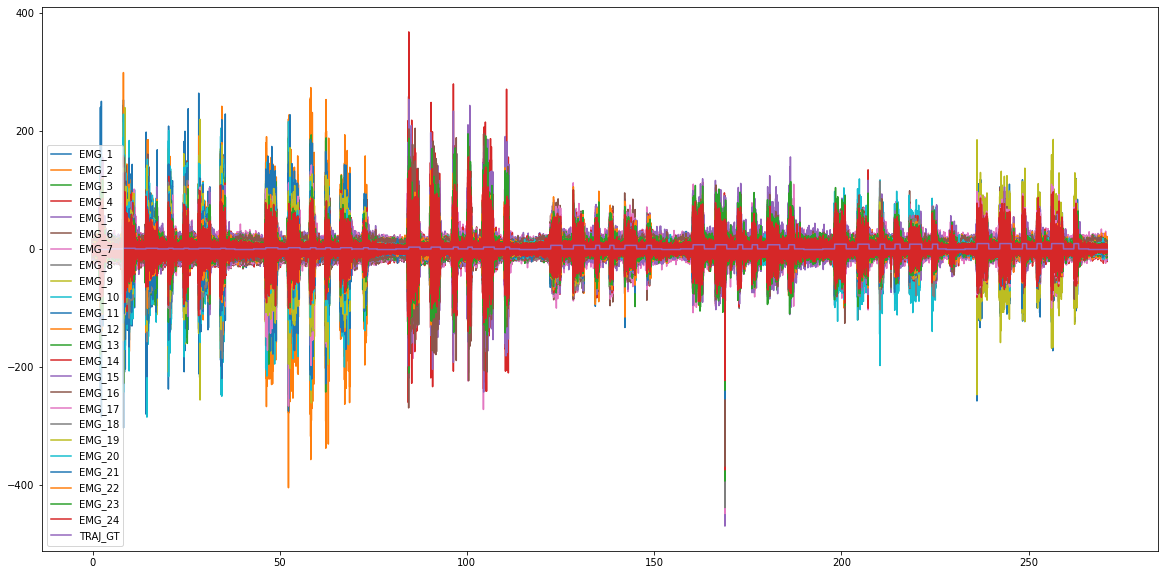

In [12]:
EMG_Frame_filetered.plot(figsize=(20,10))

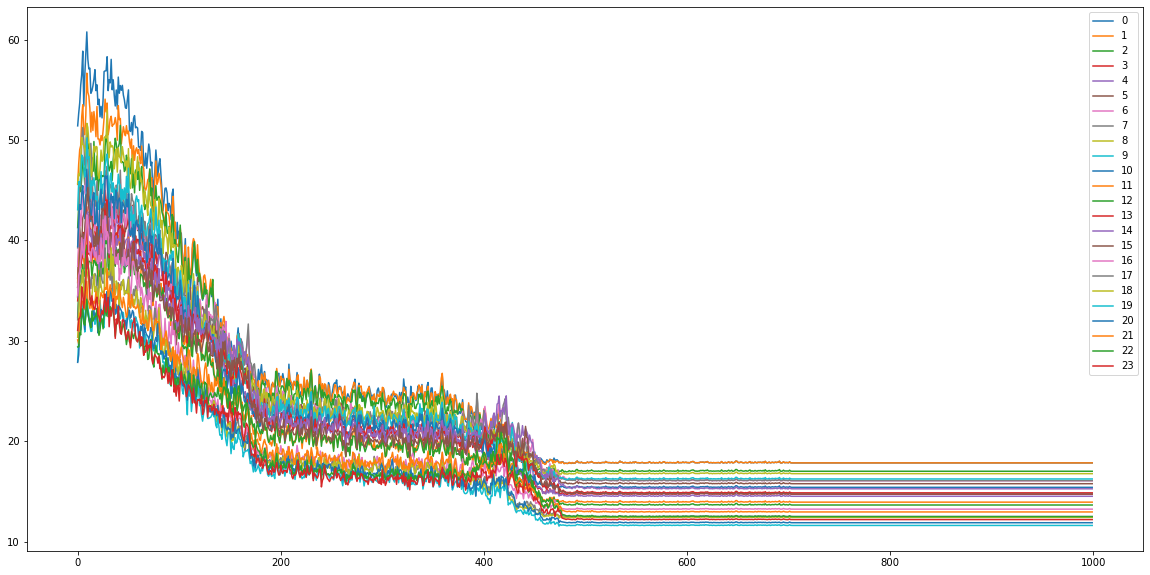

In [32]:
plt.figure(figsize=(20,10))
plt.plot(np.arange(1000), shortGestArrs[1].mean(axis=0))
plt.legend(range(24))
clear_output()

- Кожен з наявних в вибірці рухів має своє співвідношення напруг датчиків упродовж виконання, що не змінюється упродовж виконання руху
- Зменшення довжини патернів за допомогою знаходження максимуму деякої кількості сусідніх значень напруги збільшує візуальну різницю та відстані між реалізаціями різних класів у гіперпросторі, порівняно із використанням середнього значення
- На значення серединних векторів семплів сильно впливає розходження за фазою записаних патернів
- Можна додати контур селекції за інформативністю ознак
- Зі збільшенням вибірки росте негативний вплив неспівпадіння фаз кожного патерну

Можливо, онлайнове розпізнавання слід проводити не по цілому патерну руху, а по співвідношенням показників різних датчиків та відповідних екстрагованих властивостей впродовж виконання руху.<br> 
Якщо брати патерн руху в цілому, то постають питання:
1. затримки відклику протезу на початок руху
2. розпізнавання рухів виконаних з різною швидкістю


### М'який алгоритм синхронізації вибірки по фазі:
1. Брати патерни попарно починаючи з 0 індексу. Зміщувати завжди на 1 дискрету
1. Розраховувати та запам'ятати критерій синхрнизації - Декартову відстань між вікнами патерну.
1. Лічильник кроків +1. Перейти до 4.
1. Якщо лічильник кроків > 0: Вікно другого в парі патерну змістити праворуч. В супротивному випадку вікно першого - ліворуч.
1. Розрахувати та запам'ятати новий критерій синхрнизації - Декартову відстань між вікнами патерну. Перейти до 6.
1. Якщо критерій > попереднього свого значенню перейти до 7. Якщо менше - перейти до 3.
1. Якщо перший прохід виконати 8. 9. 2 рази, якщо ні - 1 раз.
1. Лічильник кроків -1. Перейти до 8.
1. Якщо лічильник < 0 Змістити вікно першого патерну праворуч. В супротивному випадку - вікно другого патерну ліворуч. 
1. Перейти до 5. 
1. Лічильник кроків -1
1. 

In [13]:
plt.figure(figsize=(20,10))
plt.plot(np.arange(1000), center)

In [15]:
from datetime import datetime

In [20]:
t0 = time.process_time()
time.process_time()  - t0

3.330099999843128e-05

N - об'єм вибірки одного класу... Мабуть

In [36]:
N = 200

In [37]:
def heming(arrA, arrB):
    A = arrA.reshape(-1)
    B = arrB.reshape(-1)
    result = 0
    for i,val in enumerate(A.T):
            result += 0 if val == B[i] else 1
    return result       

In [38]:
def k13(rds, h_cntr_rls):
    return len(h_cntr_rls[h_cntr_rls <= rds])

In [39]:
def k24(rds, h_cntr_rls):
    return len(h_cntr_rls[h_cntr_rls > rds])

Можна спробувати визначити градієнт $ E^{0} $ з метою реалізації послідовного алгоритму оптимізації контрольних допусків

In [40]:
def kulbak(N,K2,K3):
    K23 = K2 + K3;
    return (1.0/N) * np.log2((2*N + 10.0**(-8) - np.floor(K23)) / (np.floor(K23) + 10.0**(-8))) * round(N - K23,0)

In [41]:
def binearize (image, top, bottom):    
    return np.logical_and(np.greater_equal(top, image), np.greater_equal(image, bottom)).astype(int)

### Реалізовано оптимізацію радіусу контейнера базового класу:

In [42]:
def radius_opt(h_cntr_rls, r_max):
    radius = 0
    result = 0
    best_kulbak = 0
    while radius < r_max :
        klbk = kulbak(N, k24(radius, h_cntr_rls[0]), k13(radius, h_cntr_rls[1]))
        if klbk >= best_kulbak :
            best_kulbak = klbk
            result = radius
        else:
            break
        radius += 1
    return (result, best_kulbak)

Немає можливості знайти відстань між найближчими сусідами через те, що відстані між бінеаризованими центрами всі по 0

### Процес оптимізації параметрів контейнерів

In [34]:
shortGestArrs = shortGestArrs.reshape((8,200,-1))

In [46]:
shortGestArrs.shape

(8, 200, 24000)

In [44]:
centers = shortGestArrs.mean(axis=1)
d_top = 30
d_bottom = 1
cont_deltas = []
bin_centers = []
cont_radiuses = []
# Цикл що почергово формує правила для класів
for z in range(0,shortGestArrs.shape[0]):
    print("Start for class " + str(z))
#     Паралельна оптимізація контрольних допусків
#     if z == 0:
#         delta = 9.0
#     else:
    delta = d_top
    best_kulbak, best_radius,best_delta = 0., 0., 0.
    best_center = None
    sum_hems = 0
    while delta > d_bottom:
#         time.sleep(2)
#         clear_output()
        t = t0 = time.process_time()
        binary = np.array([binearize(sample, centers[z] + delta, centers[z] - delta) for sample in shortGestArrs])
#         print("Binary formed in " + str(time.process_time()  - t0) + " s")
        selection = 0.5
        
        binearized_centers = (binary.mean(axis=1) > selection).astype(int)
        
        t0 = time.process_time()
        center_hems = np.array([heming(binearized_centers[z],v) for v in np.delete(binearized_centers, z, axis=0)])
        
        if np.any(center_hems == 0) or sum_hems >= center_hems.sum():
            delta -= 0.5
            continue
        else:
            sum_hems = center_hems.sum()
        print("Delta optimization " + str(delta))
        nrst_nhbr = np.where(center_hems == center_hems.min())[0][0]
        print(center_hems)
        rl_nhbr = nrst_nhbr + 1 if nrst_nhbr >= z else nrst_nhbr
        print("Nearest neighbour detected in " + str(time.process_time()  - t0) + " s, Nrst nhbr = " + str(rl_nhbr))
        
        
        hems_center_reals = np.array([[np.array([heming(val, realization) for realization in v]) for v in np.take(binary, [z, nrst_nhbr], axis=0)]
                             for val in np.take(binearized_centers, [z, nrst_nhbr], axis=0)])

        radius, klbk = radius_opt(hems_center_reals[0], center_hems.min());
        if klbk >= best_kulbak:
            best_delta = delta
            best_radius = radius
            best_kulbak = klbk
            best_center = binearized_centers[z]
        else: break
        delta -= 0.5
        if best_kulbak > 0:
            print("Delta loop time " + str(time.process_time()  - t) + " s, Kulbak=" + str(best_kulbak))
#     Послідовна оптимізація контрольних допусків
#     deltas = np.zeros(shortGestArrs[0,0].shape)
#     deltas.fill(best_delta)
#     i = 0
#     while i < deltas.shape[0]:
#         deltas[i] =  deltas[i] - 1
#         binary = np.array([binearize(shortGestArrs[z], centers[z] + deltas, centers[z] - deltas) for sample in shortGestArrs])

#         selection = 0.5

#         binearized_centers = (binary.mean(axis=1) > selection).astype(int)

#         center_hems = np.array([heming(binearized_centers[z],v) for v in np.delete(binearized_centers, z, axis=0)])
#         nrst_nhbr = np.where(center_hems == center_hems.min())[0][0]
#         center_hems = center_hems[nrst_nhbr]
        
#         hems_center_reals = np.array([[np.array([heming(val, realization) for realization in v]) for v in np.take(binary, [z, nrst_nhbr], axis=0)]
#                              for val in np.take(binearized_centers, [z, nrst_nhbr], axis=0)])

#         maxK0 = hems_center_reals[0,0].max()

#         radiusK0 = maxK0 if maxK0 < center_hems.min() else center_hems.min() - 1

#         radius, klbk = radius_opt(hems_center_reals[0], radiusK0);
#         if klbk > best_kulbak:
#             print(deltas[i], klbk)
#             best_radius = radius
#             best_kulbak = klbk
#             best_center = binearized_centers[z]
#         elif i < deltas.shape[0] - 1:
#             print(i)
#             deltas[i] += 1
#             i+=1
#         else: break    
    cont_deltas.append(delta)
    bin_centers.append(best_center)
    cont_radiuses.append(best_radius)
    print("Best kulbak = "+str(best_kulbak)+" Best radius = "+str(best_radius))
cont_deltas = np.array(cont_deltas)

Start for class 0
Delta optimization 14.5
[2040  978 4567   20    1    2    3]
Nearest neighbour detected in 0.04425591900000114 s, Nrst nhbr = 5
Delta optimization 14.0
[2161 1038 4750   23    6    3    6]
Nearest neighbour detected in 0.04498661499999912 s, Nrst nhbr = 6
Delta optimization 13.5
[2313 1102 4976   33   18   16   16]
Nearest neighbour detected in 0.04461797800000511 s, Nrst nhbr = 6
Delta optimization 13.0
[2447 1181 6179   32   28   24   24]
Nearest neighbour detected in 0.04768410200000517 s, Nrst nhbr = 6
Delta optimization 12.5
[2610 1275 7459   28   24   22   24]
Nearest neighbour detected in 0.046533659000004945 s, Nrst nhbr = 6
Delta optimization 12.0
[2791 1392 7807   23   19   21   25]
Nearest neighbour detected in 0.04493208000000948 s, Nrst nhbr = 5
Delta optimization 11.5
[2948 1518 8588   28   27   29   31]
Nearest neighbour detected in 0.045444927000005464 s, Nrst nhbr = 5
Delta optimization 11.0
[3144 1692 8987   38   37   44   46]
Nearest neighbour detec

Start for class 0
Delta optimization 22.5
Nearest neighbour detected in 0.04058690700000511 s, Nrst nhbr = 0
Delta optimization 22.0
Nearest neighbour detected in 0.03876912700002322 s, Nrst nhbr = 0
Delta optimization 21.5
Nearest neighbour detected in 0.03967338000001064 s, Nrst nhbr = 0
Delta optimization 21.0
Nearest neighbour detected in 0.04028318799998942 s, Nrst nhbr = 0
Delta optimization 20.5
Nearest neighbour detected in 0.04099905900000067 s, Nrst nhbr = 0
Delta optimization 20.0
Nearest neighbour detected in 0.043357338999982176 s, Nrst nhbr = 0
Delta optimization 19.5
Nearest neighbour detected in 0.046024512999991884 s, Nrst nhbr = 0
Delta optimization 19.0
Nearest neighbour detected in 0.03988589799999431 s, Nrst nhbr = 0
Delta optimization 18.5
Nearest neighbour detected in 0.039880758000009564 s, Nrst nhbr = 0
Delta optimization 18.0
Nearest neighbour detected in 0.03993809000002102 s, Nrst nhbr = 0
Delta optimization 17.5
Nearest neighbour detected in 0.04634904200000278 s, Nrst nhbr = 0
Delta optimization 17.0
Nearest neighbour detected in 0.03930737900000736 s, Nrst nhbr = 0
Delta optimization 16.5
Nearest neighbour detected in 0.04349664399998687 s, Nrst nhbr = 0
Delta optimization 16.0
Nearest neighbour detected in 0.0397451419999868 s, Nrst nhbr = 0
Delta optimization 15.5
Nearest neighbour detected in 0.039668776000013395 s, Nrst nhbr = 0
Delta optimization 15.0
Nearest neighbour detected in 0.04033974300000409 s, Nrst nhbr = 0
Delta optimization 14.5
Nearest neighbour detected in 0.04324210099997572 s, Nrst nhbr = 0
Delta optimization 14.0
Nearest neighbour detected in 0.041378958999985116 s, Nrst nhbr = 0
Delta optimization 13.5
Nearest neighbour detected in 0.040597645999980614 s, Nrst nhbr = 0
Delta optimization 13.0
Nearest neighbour detected in 0.04042554000000109 s, Nrst nhbr = 0
Delta optimization 12.5
Nearest neighbour detected in 0.042180848999976206 s, Nrst nhbr = 0
Delta optimization 12.0
Nearest neighbour detected in 0.04144839700001057 s, Nrst nhbr = 0
Delta optimization 11.5
Nearest neighbour detected in 0.04128840899994657 s, Nrst nhbr = 0
Delta optimization 11.0
Nearest neighbour detected in 0.041310740999961126 s, Nrst nhbr = 0
Delta optimization 10.5
Nearest neighbour detected in 0.04199476200000163 s, Nrst nhbr = 0
Delta optimization 10.0
Nearest neighbour detected in 0.04222690699998566 s, Nrst nhbr = 0
Delta optimization 9.5
Nearest neighbour detected in 0.046393824000006134 s, Nrst nhbr = 0
Delta optimization 9.0
Nearest neighbour detected in 0.04060112399997706 s, Nrst nhbr = 0
Delta optimization 8.5
Nearest neighbour detected in 0.041837396000005356 s, Nrst nhbr = 0
Delta optimization 8.0
Nearest neighbour detected in 0.040661248000049 s, Nrst nhbr = 0
0 0
Start for class 1
Delta optimization 24.5
Nearest neighbour detected in 0.03929324800003542 s, Nrst nhbr = 0
Delta optimization 24.0
Nearest neighbour detected in 0.04009382399999595 s, Nrst nhbr = 0
Delta optimization 23.5
Nearest neighbour detected in 0.03975532499998735 s, Nrst nhbr = 0
Delta optimization 23.0
Nearest neighbour detected in 0.03898120299999164 s, Nrst nhbr = 0
Delta optimization 22.5
Nearest neighbour detected in 0.038926370000012867 s, Nrst nhbr = 0
Delta optimization 22.0
Nearest neighbour detected in 0.03874307800003862 s, Nrst nhbr = 0
Delta optimization 21.5
Nearest neighbour detected in 0.03921516700000893 s, Nrst nhbr = 0
Delta optimization 21.0
Nearest neighbour detected in 0.03965594900000724 s, Nrst nhbr = 0
Delta optimization 20.5
Nearest neighbour detected in 0.03935477999999648 s, Nrst nhbr = 0
Delta optimization 20.0
Nearest neighbour detected in 0.040083530000003975 s, Nrst nhbr = 0
Delta optimization 19.5
Nearest neighbour detected in 0.039916776999973536 s, Nrst nhbr = 0
Delta optimization 19.0
Nearest neighbour detected in 0.03951071400001638 s, Nrst nhbr = 0
Delta optimization 18.5
Nearest neighbour detected in 0.03965219700000944 s, Nrst nhbr = 0
Delta optimization 18.0
Nearest neighbour detected in 0.03944304699996337 s, Nrst nhbr = 0
Delta optimization 17.5
Nearest neighbour detected in 0.03900783000000274 s, Nrst nhbr = 0
Delta optimization 17.0
Nearest neighbour detected in 0.03751980099997354 s, Nrst nhbr = 0
Delta optimization 16.5
Nearest neighbour detected in 0.04765028200000643 s, Nrst nhbr = 0
Delta optimization 16.0
Nearest neighbour detected in 0.04032183200001782 s, Nrst nhbr = 0
Delta optimization 15.5
Nearest neighbour detected in 0.04041551000000254 s, Nrst nhbr = 0
Delta optimization 15.0
Nearest neighbour detected in 0.04431538199997931 s, Nrst nhbr = 0
Delta optimization 14.5
Nearest neighbour detected in 0.039061083999968105 s, Nrst nhbr = 0
Delta optimization 14.0
Nearest neighbour detected in 0.04026597700004686 s, Nrst nhbr = 0
Delta optimization 13.5
Nearest neighbour detected in 0.04050630300002922 s, Nrst nhbr = 0
Delta optimization 13.0
Nearest neighbour detected in 0.03939023000003772 s, Nrst nhbr = 0
Delta optimization 12.5
Nearest neighbour detected in 0.04031164600002057 s, Nrst nhbr = 0
Delta optimization 12.0
Nearest neighbour detected in 0.04224056399999654 s, Nrst nhbr = 0
Delta optimization 11.5
Nearest neighbour detected in 0.040672979999953895 s, Nrst nhbr = 0
Delta loop time 6.08840307600002 s, Kulbak=7.213535317279155e-05
Delta optimization 11.0
Nearest neighbour detected in 0.040725808000047437 s, Nrst nhbr = 0
7.213535317279155e-05 28
Start for class 2
Delta optimization 30
Nearest neighbour detected in 0.04053223300002173 s, Nrst nhbr = 0
Delta optimization 29.5
Nearest neighbour detected in 0.03939376599998923 s, Nrst nhbr = 0
Delta optimization 29.0
Nearest neighbour detected in 0.03931456399993749 s, Nrst nhbr = 0
Delta optimization 28.5
Nearest neighbour detected in 0.039029435999964335 s, Nrst nhbr = 0
Delta optimization 28.0
Nearest neighbour detected in 0.03980466300004082 s, Nrst nhbr = 0
Delta optimization 27.5
Nearest neighbour detected in 0.04040592800004106 s, Nrst nhbr = 0
Delta optimization 27.0
Nearest neighbour detected in 0.04028608900000563 s, Nrst nhbr = 0
Delta optimization 26.5
Nearest neighbour detected in 0.048501848999990216 s, Nrst nhbr = 0
Delta loop time 5.865285483999969 s, Kulbak=0.002597630549752766
Delta optimization 26.0
Nearest neighbour detected in 0.039783019999958924 s, Nrst nhbr = 0
Delta loop time 5.920755733999954 s, Kulbak=0.005846863681738295
Delta optimization 25.5
Nearest neighbour detected in 0.0403210400000944 s, Nrst nhbr = 0
Delta loop time 5.951137544999938 s, Kulbak=0.020897368502587204
Delta optimization 25.0
Nearest neighbour detected in 0.03947871499997291 s, Nrst nhbr = 0
Delta loop time 5.9280167050000045 s, Kulbak=0.03832885022935681
Delta optimization 24.5
Nearest neighbour detected in 0.04108248600005027 s, Nrst nhbr = 0
Delta loop time 5.954871143999981 s, Kulbak=0.061095934612503275
Delta optimization 24.0
Nearest neighbour detected in 0.04188858200006962 s, Nrst nhbr = 0
Delta loop time 6.030051092000008 s, Kulbak=0.09990279250831598
Delta optimization 23.5
Nearest neighbour detected in 0.0409590299999536 s, Nrst nhbr = 0
Delta loop time 6.081065187000036 s, Kulbak=0.14197372610680256
Delta optimization 23.0
Nearest neighbour detected in 0.04156246499996996 s, Nrst nhbr = 0
Delta loop time 5.983844928999929 s, Kulbak=0.1918556335295621
Delta optimization 22.5
Nearest neighbour detected in 0.04214561699996011 s, Nrst nhbr = 0
Delta loop time 6.1763703430000305 s, Kulbak=0.20758012590145908
Delta optimization 22.0
Nearest neighbour detected in 0.04126720299996123 s, Nrst nhbr = 0
Delta loop time 5.999664922999955 s, Kulbak=0.24103966552566003
Delta optimization 21.5
Nearest neighbour detected in 0.04207505800002309 s, Nrst nhbr = 0
Delta loop time 5.939614429000017 s, Kulbak=0.2587907958961375
Delta optimization 21.0
Nearest neighbour detected in 0.040253757000073165 s, Nrst nhbr = 0
Delta loop time 5.918393808000019 s, Kulbak=0.2772343017583478
Delta optimization 20.5
Nearest neighbour detected in 0.04017631299996083 s, Nrst nhbr = 0
Delta loop time 5.940064010000015 s, Kulbak=0.2867185488600389
Delta optimization 20.0
Nearest neighbour detected in 0.042517293999935646 s, Nrst nhbr = 0
0.2867185488600389 180
Start for class 3
Delta optimization 29.0
Nearest neighbour detected in 0.03960880799991173 s, Nrst nhbr = 0
Delta optimization 28.5
Nearest neighbour detected in 0.03996351000000686 s, Nrst nhbr = 0
Delta optimization 28.0
Nearest neighbour detected in 0.04036651300009453 s, Nrst nhbr = 0
Delta optimization 27.5
Nearest neighbour detected in 0.0414102739999862 s, Nrst nhbr = 0
Delta optimization 27.0
Nearest neighbour detected in 0.0397528199999897 s, Nrst nhbr = 0
Delta optimization 26.5
Nearest neighbour detected in 0.04288838000002215 s, Nrst nhbr = 0
Delta optimization 26.0
Nearest neighbour detected in 0.0387786280000455 s, Nrst nhbr = 0
Delta optimization 25.5
Nearest neighbour detected in 0.03904669499991087 s, Nrst nhbr = 0
Delta optimization 25.0
Nearest neighbour detected in 0.041263145000016266 s, Nrst nhbr = 0
Delta optimization 24.5
Nearest neighbour detected in 0.040183715000011944 s, Nrst nhbr = 0
Delta optimization 24.0
Nearest neighbour detected in 0.04047982199995204 s, Nrst nhbr = 0
Delta optimization 23.5
Nearest neighbour detected in 0.04170711200004007 s, Nrst nhbr = 0
Delta optimization 23.0
Nearest neighbour detected in 0.05713337200006663 s, Nrst nhbr = 0
Delta optimization 22.5
Nearest neighbour detected in 0.040045276999990165 s, Nrst nhbr = 0
Delta optimization 22.0
Nearest neighbour detected in 0.043342512999970495 s, Nrst nhbr = 0
Delta optimization 21.5
Nearest neighbour detected in 0.03824391099999502 s, Nrst nhbr = 0
Delta optimization 21.0
Nearest neighbour detected in 0.039954032999958145 s, Nrst nhbr = 0
Delta optimization 20.5
Nearest neighbour detected in 0.04008552100003726 s, Nrst nhbr = 0
Delta optimization 20.0
Nearest neighbour detected in 0.04010367499995482 s, Nrst nhbr = 0
Delta optimization 19.5
Nearest neighbour detected in 0.03954813699999704 s, Nrst nhbr = 0
Delta optimization 19.0
Nearest neighbour detected in 0.03990312600001289 s, Nrst nhbr = 0
Delta optimization 18.5
Nearest neighbour detected in 0.046058019000042805 s, Nrst nhbr = 0
Delta optimization 18.0
Nearest neighbour detected in 0.038971885000023576 s, Nrst nhbr = 0
Delta optimization 17.5
Nearest neighbour detected in 0.03984128599995529 s, Nrst nhbr = 1
Delta optimization 17.0
Nearest neighbour detected in 0.039390983000089363 s, Nrst nhbr = 1
Delta optimization 16.5
Nearest neighbour detected in 0.04107187499994325 s, Nrst nhbr = 1
Delta optimization 16.0
Nearest neighbour detected in 0.03921024999999645 s, Nrst nhbr = 1
Delta optimization 15.5
Nearest neighbour detected in 0.0401524999999765 s, Nrst nhbr = 1
Delta optimization 15.0
Nearest neighbour detected in 0.04532476899998983 s, Nrst nhbr = 1
Delta optimization 14.5
Nearest neighbour detected in 0.04133508999996138 s, Nrst nhbr = 1
Delta optimization 14.0
Nearest neighbour detected in 0.040291180999929566 s, Nrst nhbr = 3
Delta optimization 13.5
Nearest neighbour detected in 0.04224511999996139 s, Nrst nhbr = 3
Delta optimization 13.0
Nearest neighbour detected in 0.040803343999982644 s, Nrst nhbr = 3
Delta optimization 12.5
Nearest neighbour detected in 0.042233257000020785 s, Nrst nhbr = 3
Delta optimization 12.0
Nearest neighbour detected in 0.039755401000093116 s, Nrst nhbr = 3
Delta optimization 11.5
Nearest neighbour detected in 0.04046825799991893 s, Nrst nhbr = 3
Delta optimization 11.0
Nearest neighbour detected in 0.03979439600004753 s, Nrst nhbr = 3
Delta optimization 10.5
Nearest neighbour detected in 0.04072078399997281 s, Nrst nhbr = 3
Delta optimization 10.0
Nearest neighbour detected in 0.0406349009999758 s, Nrst nhbr = 3
Delta optimization 9.5
Nearest neighbour detected in 0.04080012999997962 s, Nrst nhbr = 3
Delta optimization 9.0
Nearest neighbour detected in 0.041220395999971515 s, Nrst nhbr = 3
Delta optimization 8.5
Nearest neighbour detected in 0.041009824000070694 s, Nrst nhbr = 3
Delta optimization 8.0
Nearest neighbour detected in 0.04721844899995631 s, Nrst nhbr = 3
0 0
Start for class 4
Delta optimization 29.0
Nearest neighbour detected in 0.04142422199993234 s, Nrst nhbr = 0
Delta optimization 28.5
Nearest neighbour detected in 0.04030488900002638 s, Nrst nhbr = 0
Delta optimization 28.0
Nearest neighbour detected in 0.03882803099998 s, Nrst nhbr = 0
Delta optimization 27.5
Nearest neighbour detected in 0.039776361000008364 s, Nrst nhbr = 0
Delta optimization 27.0
Nearest neighbour detected in 0.04050854000001891 s, Nrst nhbr = 0
Delta optimization 26.5
Nearest neighbour detected in 0.04019502799997099 s, Nrst nhbr = 0
Delta optimization 26.0
Nearest neighbour detected in 0.03959046299996771 s, Nrst nhbr = 0
Delta optimization 25.5
Nearest neighbour detected in 0.04039521999993667 s, Nrst nhbr = 0
Delta optimization 25.0
Nearest neighbour detected in 0.038398543999960566 s, Nrst nhbr = 0
Delta optimization 24.5
Nearest neighbour detected in 0.03998885800001517 s, Nrst nhbr = 0
Delta optimization 24.0
Nearest neighbour detected in 0.04031995399998323 s, Nrst nhbr = 0
Delta optimization 23.5
Nearest neighbour detected in 0.046561637999957384 s, Nrst nhbr = 0
Delta optimization 23.0
Nearest neighbour detected in 0.04116177499997775 s, Nrst nhbr = 0
Delta optimization 22.5
Nearest neighbour detected in 0.041025289000003795 s, Nrst nhbr = 0
Delta optimization 22.0
Nearest neighbour detected in 0.040733618999979626 s, Nrst nhbr = 0
Delta optimization 21.5
Nearest neighbour detected in 0.040276974999983395 s, Nrst nhbr = 0
Delta optimization 21.0
Nearest neighbour detected in 0.03919826599997123 s, Nrst nhbr = 0
Delta optimization 20.5
Nearest neighbour detected in 0.04014922800001841 s, Nrst nhbr = 0
Delta optimization 20.0
Nearest neighbour detected in 0.03864175000001069 s, Nrst nhbr = 0
Delta optimization 19.5
Nearest neighbour detected in 0.03928394299998672 s, Nrst nhbr = 0
Delta optimization 19.0
Nearest neighbour detected in 0.03987309800004368 s, Nrst nhbr = 0
Delta optimization 18.5
Nearest neighbour detected in 0.040325752999933684 s, Nrst nhbr = 0
Delta optimization 18.0
Nearest neighbour detected in 0.0446885219998876 s, Nrst nhbr = 0
Delta optimization 17.5
Nearest neighbour detected in 0.03979022799990162 s, Nrst nhbr = 0
Delta optimization 17.0
Nearest neighbour detected in 0.04231392399992728 s, Nrst nhbr = 0
Delta optimization 16.5
Nearest neighbour detected in 0.03988370499996563 s, Nrst nhbr = 1
Delta optimization 16.0
Nearest neighbour detected in 0.03871643899992705 s, Nrst nhbr = 1
Delta optimization 15.5
Nearest neighbour detected in 0.04076940499999182 s, Nrst nhbr = 1
Delta optimization 15.0
Nearest neighbour detected in 0.03994459000000461 s, Nrst nhbr = 1
Delta optimization 14.5
Nearest neighbour detected in 0.040146927000023425 s, Nrst nhbr = 1
Delta optimization 14.0
Nearest neighbour detected in 0.047932709999940926 s, Nrst nhbr = 1
Delta optimization 13.5
Nearest neighbour detected in 0.04005766600016614 s, Nrst nhbr = 1
Delta optimization 13.0
Nearest neighbour detected in 0.041923616000076436 s, Nrst nhbr = 3
Delta optimization 12.5
Nearest neighbour detected in 0.0455080619999535 s, Nrst nhbr = 3
Delta optimization 12.0
Nearest neighbour detected in 0.040291516000024785 s, Nrst nhbr = 3
Delta optimization 11.5
Nearest neighbour detected in 0.0414751470000283 s, Nrst nhbr = 3
Delta optimization 11.0
Nearest neighbour detected in 0.04025052600013623 s, Nrst nhbr = 3
Delta optimization 10.5
Nearest neighbour detected in 0.04290550499990786 s, Nrst nhbr = 3
Delta optimization 10.0
Nearest neighbour detected in 0.03945407800006251 s, Nrst nhbr = 3
Delta optimization 9.5
Nearest neighbour detected in 0.040776319999849875 s, Nrst nhbr = 3
Delta optimization 9.0
Nearest neighbour detected in 0.041583602999935465 s, Nrst nhbr = 3
Delta optimization 8.5
Nearest neighbour detected in 0.04029360100003032 s, Nrst nhbr = 3
Delta optimization 8.0
Nearest neighbour detected in 0.04027078700005404 s, Nrst nhbr = 4
0 0
Start for class 5
Delta optimization 29.0
Nearest neighbour detected in 0.03814879799983828 s, Nrst nhbr = 0
Delta optimization 28.5
Nearest neighbour detected in 0.04133990900004392 s, Nrst nhbr = 0
Delta optimization 28.0
Nearest neighbour detected in 0.04090058199994928 s, Nrst nhbr = 0
Delta optimization 27.5
Nearest neighbour detected in 0.04212829499988402 s, Nrst nhbr = 0
Delta optimization 27.0
Nearest neighbour detected in 0.04039291700019021 s, Nrst nhbr = 0
Delta optimization 26.5
Nearest neighbour detected in 0.04045657699998628 s, Nrst nhbr = 0
Delta optimization 26.0
Nearest neighbour detected in 0.03876168300007521 s, Nrst nhbr = 0
Delta optimization 25.5
Nearest neighbour detected in 0.042102064000118844 s, Nrst nhbr = 0
Delta optimization 25.0
Nearest neighbour detected in 0.03943801000013991 s, Nrst nhbr = 0
Delta optimization 24.5
Nearest neighbour detected in 0.04294055699983801 s, Nrst nhbr = 0
Delta optimization 24.0
Nearest neighbour detected in 0.04029055099999823 s, Nrst nhbr = 0
Delta optimization 23.5
Nearest neighbour detected in 0.04313385199998265 s, Nrst nhbr = 0
Delta optimization 23.0
Nearest neighbour detected in 0.040661860999989585 s, Nrst nhbr = 0
Delta optimization 22.5
Nearest neighbour detected in 0.03916703400000188 s, Nrst nhbr = 0
Delta optimization 22.0
Nearest neighbour detected in 0.03986166099980437 s, Nrst nhbr = 0
Delta optimization 21.5
Nearest neighbour detected in 0.040027028999929826 s, Nrst nhbr = 0
Delta optimization 21.0
Nearest neighbour detected in 0.04010035700002845 s, Nrst nhbr = 0
Delta optimization 20.5
Nearest neighbour detected in 0.04058391500007019 s, Nrst nhbr = 0
Delta optimization 20.0
Nearest neighbour detected in 0.04063604199996007 s, Nrst nhbr = 0
Delta optimization 19.5
Nearest neighbour detected in 0.04039509399990493 s, Nrst nhbr = 0
Delta optimization 19.0
Nearest neighbour detected in 0.041084412000145676 s, Nrst nhbr = 0
Delta optimization 18.5
Nearest neighbour detected in 0.04067948100009744 s, Nrst nhbr = 0
Delta optimization 18.0
Nearest neighbour detected in 0.04109705199994096 s, Nrst nhbr = 0
Delta optimization 17.5
Nearest neighbour detected in 0.042099943999801326 s, Nrst nhbr = 0
Delta optimization 17.0
Nearest neighbour detected in 0.04129671900000176 s, Nrst nhbr = 0
Delta optimization 16.5
Nearest neighbour detected in 0.040232263999996576 s, Nrst nhbr = 0
Delta optimization 16.0
Nearest neighbour detected in 0.040003361000117366 s, Nrst nhbr = 1
Delta optimization 15.5
Nearest neighbour detected in 0.040218541000058394 s, Nrst nhbr = 1
Delta optimization 15.0
Nearest neighbour detected in 0.04092178800010515 s, Nrst nhbr = 1
Delta optimization 14.5
Nearest neighbour detected in 0.041247813999916616 s, Nrst nhbr = 1
Delta optimization 14.0
Nearest neighbour detected in 0.03982296599997426 s, Nrst nhbr = 1
Delta optimization 13.5
Nearest neighbour detected in 0.04020758299998306 s, Nrst nhbr = 1
Delta optimization 13.0
Nearest neighbour detected in 0.04198391199997786 s, Nrst nhbr = 1
Delta optimization 12.5
Nearest neighbour detected in 0.03975736000006691 s, Nrst nhbr = 3
Delta optimization 12.0
Nearest neighbour detected in 0.043211938000013106 s, Nrst nhbr = 3
Delta optimization 11.5
Nearest neighbour detected in 0.03864496100004544 s, Nrst nhbr = 3
Delta optimization 11.0
Nearest neighbour detected in 0.04412623200005328 s, Nrst nhbr = 3
Delta optimization 10.5
Nearest neighbour detected in 0.03971487900003012 s, Nrst nhbr = 3
Delta optimization 10.0
Nearest neighbour detected in 0.039595440000084636 s, Nrst nhbr = 3
Delta optimization 9.5
Nearest neighbour detected in 0.04062227500003246 s, Nrst nhbr = 3
Delta optimization 9.0
Nearest neighbour detected in 0.04052954200005843 s, Nrst nhbr = 3
Delta optimization 8.5
Nearest neighbour detected in 0.05819600399991032 s, Nrst nhbr = 3
Delta optimization 8.0
Nearest neighbour detected in 0.04191023299995322 s, Nrst nhbr = 3
0 0
Start for class 6
Delta optimization 28.5
Nearest neighbour detected in 0.04053537899994808 s, Nrst nhbr = 0
Delta optimization 28.0
Nearest neighbour detected in 0.04134858600014013 s, Nrst nhbr = 0
Delta optimization 27.5
Nearest neighbour detected in 0.04027335899991158 s, Nrst nhbr = 0
Delta optimization 27.0
Nearest neighbour detected in 0.05112236200011466 s, Nrst nhbr = 0
Delta optimization 26.5
Nearest neighbour detected in 0.04114922000007937 s, Nrst nhbr = 0
Delta optimization 26.0
Nearest neighbour detected in 0.04486172999986593 s, Nrst nhbr = 0
Delta optimization 25.5
Nearest neighbour detected in 0.04169842999999673 s, Nrst nhbr = 0
Delta optimization 25.0
Nearest neighbour detected in 0.04005486200003361 s, Nrst nhbr = 0
Delta optimization 24.5
Nearest neighbour detected in 0.04405766499985475 s, Nrst nhbr = 0
Delta optimization 24.0
Nearest neighbour detected in 0.04037465400006113 s, Nrst nhbr = 0
Delta optimization 23.5
Nearest neighbour detected in 0.05364900399990802 s, Nrst nhbr = 0
Delta optimization 23.0
Nearest neighbour detected in 0.03956704499978514 s, Nrst nhbr = 0
Delta optimization 22.5
Nearest neighbour detected in 0.041428465000080905 s, Nrst nhbr = 0
Delta optimization 22.0
Nearest neighbour detected in 0.05203594099998554 s, Nrst nhbr = 0
Delta optimization 21.5
Nearest neighbour detected in 0.03995647200008534 s, Nrst nhbr = 0
Delta optimization 21.0
Nearest neighbour detected in 0.04158223399986127 s, Nrst nhbr = 0
Delta optimization 20.5
Nearest neighbour detected in 0.03956814299999678 s, Nrst nhbr = 0
Delta optimization 20.0
Nearest neighbour detected in 0.04059623900002407 s, Nrst nhbr = 0
Delta optimization 19.5
Nearest neighbour detected in 0.039434506000134206 s, Nrst nhbr = 0
Delta optimization 19.0
Nearest neighbour detected in 0.041528176000156236 s, Nrst nhbr = 0
Delta optimization 18.5
Nearest neighbour detected in 0.04440644499982227 s, Nrst nhbr = 0
Delta optimization 18.0
Nearest neighbour detected in 0.04069909500003632 s, Nrst nhbr = 0
Delta optimization 17.5
Nearest neighbour detected in 0.04111958499993307 s, Nrst nhbr = 0
Delta optimization 17.0
Nearest neighbour detected in 0.0413474640001823 s, Nrst nhbr = 0
Delta optimization 16.5
Nearest neighbour detected in 0.04101941699991585 s, Nrst nhbr = 1
Delta optimization 16.0
Nearest neighbour detected in 0.04031685299992205 s, Nrst nhbr = 1
Delta optimization 15.5
Nearest neighbour detected in 0.04098872299982759 s, Nrst nhbr = 1
Delta optimization 15.0
Nearest neighbour detected in 0.040467302000024574 s, Nrst nhbr = 1
Delta optimization 14.5
Nearest neighbour detected in 0.040956728000082876 s, Nrst nhbr = 1
Delta optimization 14.0
Nearest neighbour detected in 0.04081390599981205 s, Nrst nhbr = 1
Delta optimization 13.5
Nearest neighbour detected in 0.040657846999920366 s, Nrst nhbr = 3
Delta optimization 13.0
Nearest neighbour detected in 0.03817199199988863 s, Nrst nhbr = 3
Delta optimization 12.5
Nearest neighbour detected in 0.04130516300006093 s, Nrst nhbr = 3
Delta optimization 12.0
Nearest neighbour detected in 0.040243403999966176 s, Nrst nhbr = 3
Delta optimization 11.5
Nearest neighbour detected in 0.04254559099990729 s, Nrst nhbr = 3
Delta optimization 11.0
Nearest neighbour detected in 0.03960359100005917 s, Nrst nhbr = 3
Delta optimization 10.5
Nearest neighbour detected in 0.04041327799995997 s, Nrst nhbr = 3
Delta optimization 10.0
Nearest neighbour detected in 0.041878494999991744 s, Nrst nhbr = 3
Delta optimization 9.5
Nearest neighbour detected in 0.04047139099998276 s, Nrst nhbr = 3
Delta optimization 9.0
Nearest neighbour detected in 0.04092691300002116 s, Nrst nhbr = 3
Delta optimization 8.5
Nearest neighbour detected in 0.040479446999825086 s, Nrst nhbr = 3
Delta optimization 8.0
Nearest neighbour detected in 0.04103696099991794 s, Nrst nhbr = 3
0 0

In [45]:
print(cont_deltas)
print(bin_centers)
print(cont_radiuses)

[ 1.   1.   4.  28.5  1.   1.   1.   1. ]
[array([0, 0, 0, ..., 1, 1, 1]), array([0, 0, 0, ..., 1, 1, 1]), array([0, 0, 0, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), array([0, 0, 0, ..., 1, 1, 0]), array([0, 0, 0, ..., 1, 1, 1]), array([0, 0, 0, ..., 1, 0, 1]), array([0, 0, 0, ..., 1, 1, 1])]
[2269, 2275, 2128, 473, 1372, 756, 1982, 965]


In [108]:
binary.shape

(3, 100, 100, 3)

In [22]:
new_img = Image.open('Stone2.jpg')
# bark5 = np.array(new_img)[:300, :300, :]
# bar = Image.fromarray(bark5)
new_img.thumbnail(size)
plt.imshow(new_img)

### Реалізовано алгоритм екзамену:

In [23]:
new_img = np.array(new_img).reshape(100,-1);
for z in range(0,len(cont_deltas)):
    result = 0
    admission_top = centers[z] + cont_deltas[z]
    admission_bottom = centers[z] - cont_deltas[z]
    new_binary = binearize(new_img, admission_top, admission_bottom)

    new_center_hems = np.array([heming(bin_centers[z],val) for val in new_binary])
    result = 0
    for val in new_center_hems:
        if val <=  cont_radiuses[z]:
            result += 1
    print(str(z+1) + " " + str(result))

1 11
2 56
3 0


In [31]:
print(cont_deltas)
print(len(cont_centers))
print(cont_radiuses)

[36, 34, 33]
3
[119, 128, 140]
